
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [ ]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-bdve1w14
  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-bdve1w14
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian).

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [ ]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [ ]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


text               category  \
0  \tIn certain Apple 13" RGB monitors there has ...  comp.sys.mac.hardware   
1  Does anyone know how to reach Micron?  I am in...  comp.sys.mac.hardware   
2  Hi there!\n\nCould some kind soul tell me what...  comp.sys.mac.hardware   
3                                        "auto\nfrom  comp.sys.mac.hardware   
4  \n\n    Don't believe the hype. There is no su...  comp.sys.mac.hardware   
5  What is the value of an SE (HDFD) 4/20?\n\n-David  comp.sys.mac.hardware   
6  \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...  comp.sys.mac.hardware   
7  \n\n\n    Nope. The Apple 16" monitor does not...  comp.sys.mac.hardware   
8  \n\nIs it a hidden option?  I'm using PowerStr...  comp.sys.mac.hardware   
9  \n\n\nThe previous article referred to the fac...  comp.sys.mac.hardware   

                                         source_file  
0  ../data/scikit_learn_data/20news_home/20news-b...  
1  ../data/scikit_learn_data/20news_home/20news-b...  
2  ../data/scikit_learn_data/20news_home/20news-b...  
3  ../data/scikit_learn_data/20news_home/20news-b...  
4  ../data/scikit_learn_data/20news_home/20news-b...  
5  ../data/scikit_learn_data/20news_home/20news-b...  
6  ../data/scikit_learn_data/20news_home/20news-b...  
7  ../data/scikit_learn_data/20news_home/20news-b...  
8  ../data/scikit_learn_data/20news_home/20news-b...  
9  ../data/scikit_learn_data/20news_home/20news-b...

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [ ]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again.

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram).

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [ ]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [ ]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [ ]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [ ]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [ ]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms.

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [ ]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [ ]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [ ]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [ ]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [ ]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [ ]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*.

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup).

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'PredictionErrorDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'class_likelihood_ratios', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_absolute_error_score', 'd2_pinball_score', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'get_scorer_names', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [ ]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  
0     ../data/scikit_learn_data/20news_home/20news-b...                   0  
1     ../data/scikit_learn_data/20news_home/20news-b...                   0  
2     ../data/scikit_learn_data/20news_home/20news-b...                   0  
3     ../data/scikit_learn_data/20news_home/20news-b...                   0  
4     ../data/scikit_learn_data/20news_home/20news-b...                   0  
...                                                 ...                 ...  
2345  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2346  ../data/scikit_learn_data/20news_home/20news-b...                   3  
2347  ../data/scikit_learn_data/20news_home/20news-b...                   3  
2348  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2349  ../data/scikit_learn_data/20news_home/20news-b...                   0  

[2350 rows x 4 columns]

We can also look at the distinguishing features in each cluster:

In [ ]:
terms = ngTFVectorizer.get_feature_names_out()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 know
 mac
 just
 thanks
 does
 drive
 apple
 like
 don
 new


Cluster 1:
 window
 server
 use
 motif
 using
 program
 widget
 application
 code
 like


Cluster 2:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 sell
 interested
 email


Cluster 3:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

*The* cell below is optional. It allows you to do a biplot

In [ ]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [ ]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

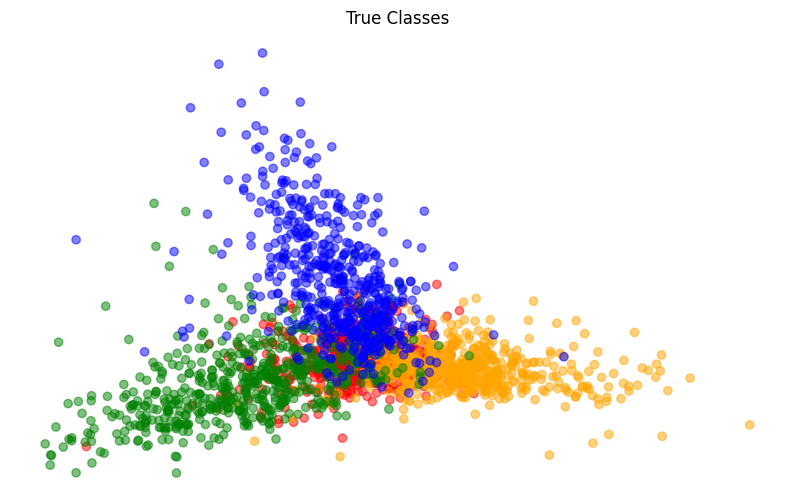

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

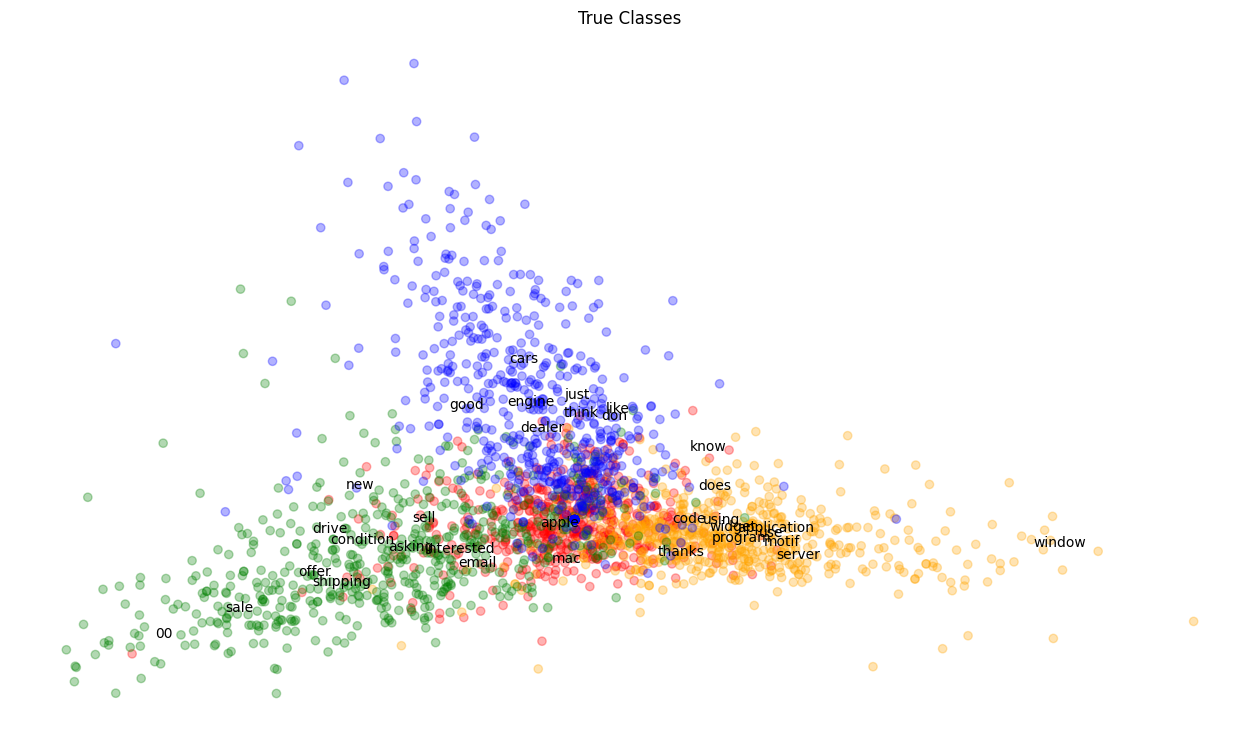

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [ ]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

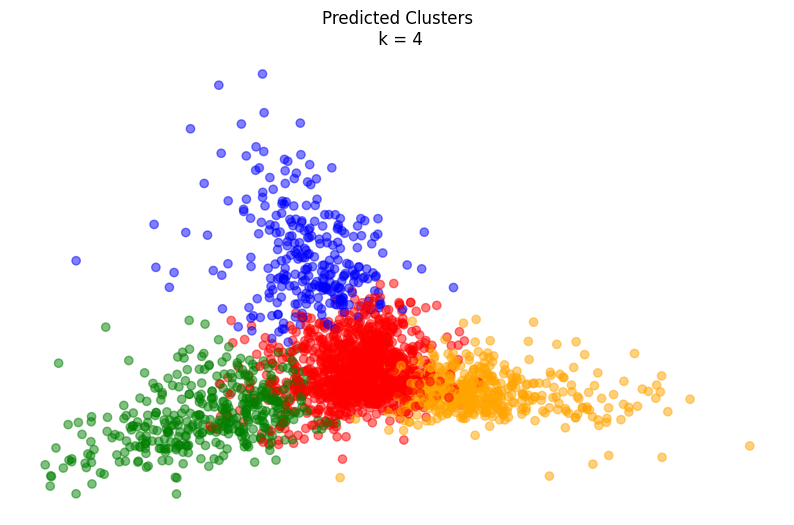

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [ ]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


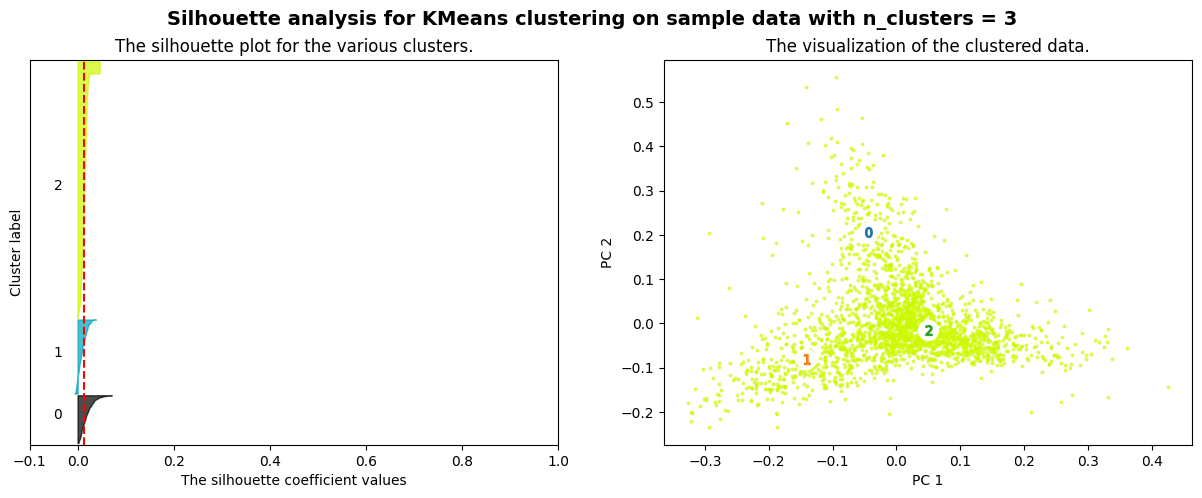

For n_clusters = 3, The average silhouette_score is : 0.014


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


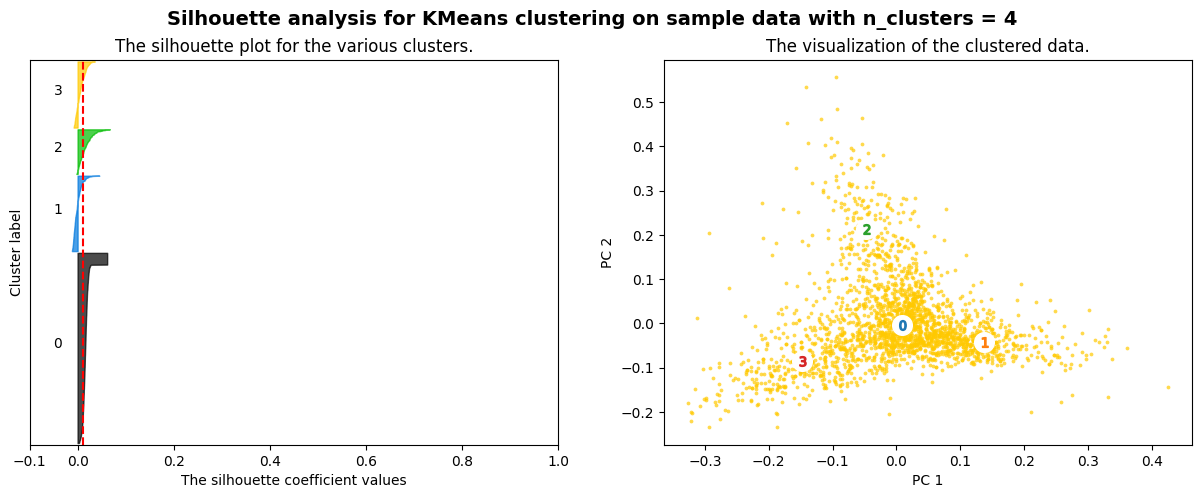

For n_clusters = 4, The average silhouette_score is : 0.012


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


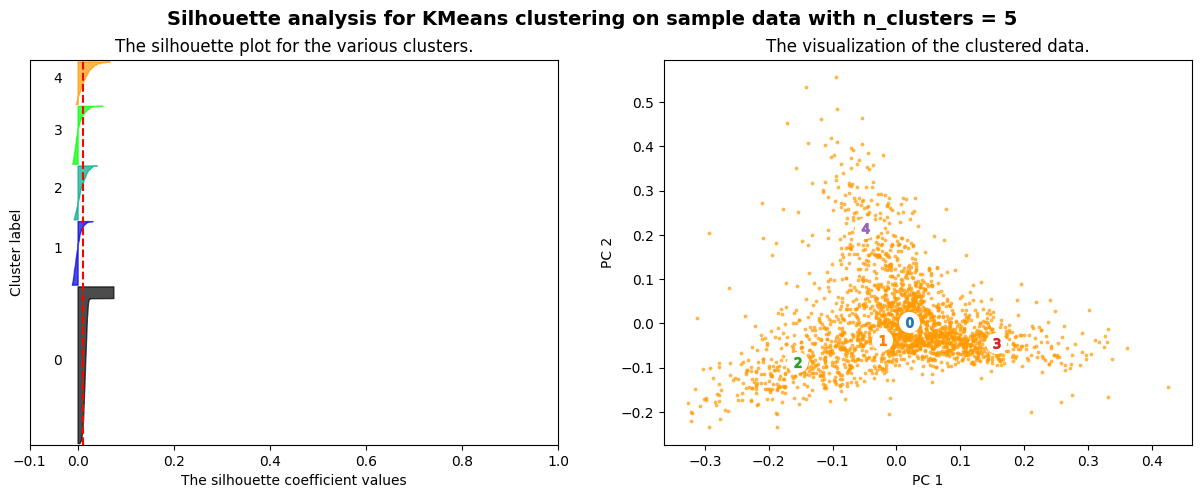

For n_clusters = 5, The average silhouette_score is : 0.011


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


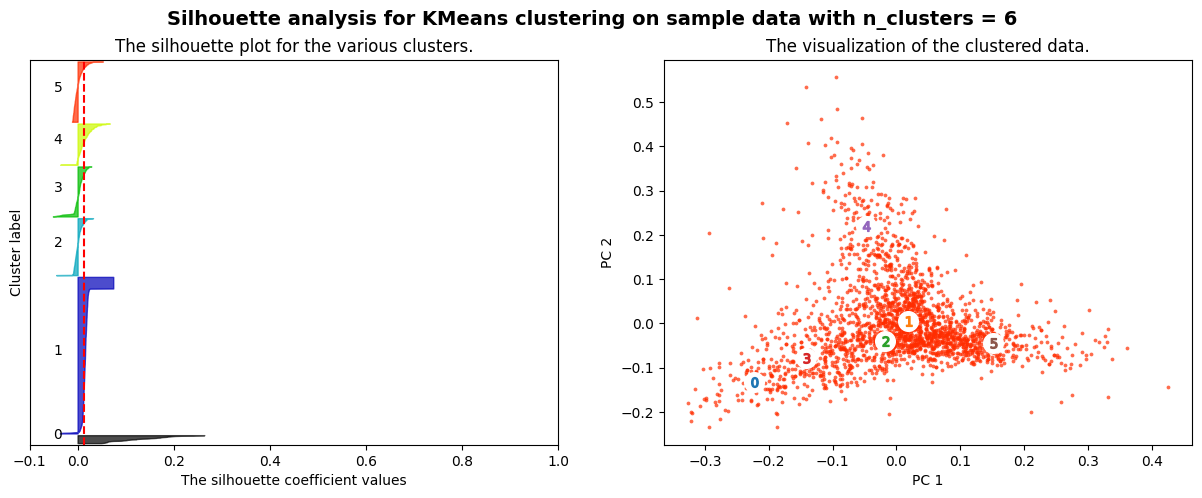

For n_clusters = 6, The average silhouette_score is : 0.013


In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../content/senReleasesTraining.csv")

senReleasesTraining[:5]

Unnamed: 0                                       download_url  \
0           0  https://raw.githubusercontent.com/lintool/Grim...   
1           1  https://raw.githubusercontent.com/lintool/Grim...   
2           2  https://raw.githubusercontent.com/lintool/Grim...   
3           3  https://raw.githubusercontent.com/lintool/Grim...   
4           4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [ ]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [ ]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [ ]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [ ]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [ ]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [ ]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

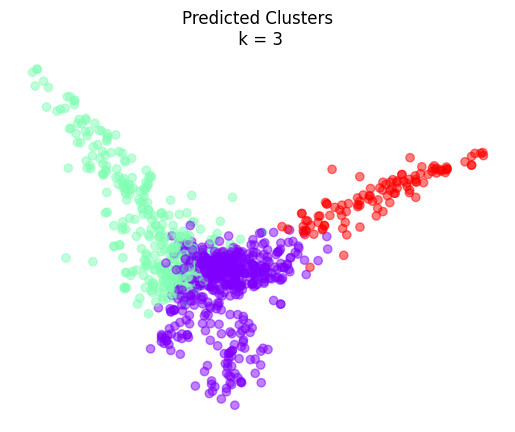

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [ ]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

Unnamed: 0                                       download_url  \
0             0  https://raw.githubusercontent.com/lintool/Grim...   
1             1  https://raw.githubusercontent.com/lintool/Grim...   
2             2  https://raw.githubusercontent.com/lintool/Grim...   
3             3  https://raw.githubusercontent.com/lintool/Grim...   
4             4  https://raw.githubusercontent.com/lintool/Grim...   
..          ...                                                ...   
994         995  https://raw.githubusercontent.com/lintool/Grim...   
995         996  https://raw.githubusercontent.com/lintool/Grim...   
996         997  https://raw.githubusercontent.com/lintool/Grim...   
997         998  https://raw.githubusercontent.com/lintool/Grim...   
998         999  https://raw.githubusercontent.com/lintool/Grim...   

                                              html_url  \
0    https://github.com/lintool/GrimmerSenatePressR...   
1    https://github.com/lintool/GrimmerSenatePressR...   
2    https://github.com/lintool/GrimmerSenatePressR...   
3    https://github.com/lintool/GrimmerSenatePressR...   
4    https://github.com/lintool/GrimmerSenatePressR...   
..                                                 ...   
994  https://github.com/lintool/GrimmerSenatePressR...   
995  https://github.com/lintool/GrimmerSenatePressR...   
996  https://github.com/lintool/GrimmerSenatePressR...   
997  https://github.com/lintool/GrimmerSenatePressR...   
998  https://github.com/lintool/GrimmerSenatePressR...   

                       name                                path  \
0    01Apr2005Kennedy14.txt  raw/Kennedy/01Apr2005Kennedy14.txt   
1    01Aug2005Kennedy12.txt  raw/Kennedy/01Aug2005Kennedy12.txt   
2    01Aug2006Kennedy10.txt  raw/Kennedy/01Aug2006Kennedy10.txt   
3    01Aug2006Kennedy11.txt  raw/Kennedy/01Aug2006Kennedy11.txt   
4    01Aug2006Kennedy12.txt  raw/Kennedy/01Aug2006Kennedy12.txt   
..                      ...                                 ...   
994  18Jul2005Kennedy13.txt  raw/Kennedy/18Jul2005Kennedy13.txt   
995  18Jul2005Kennedy14.txt  raw/Kennedy/18Jul2005Kennedy14.txt   
996   18Jul2006Kennedy0.txt   raw/Kennedy/18Jul2006Kennedy0.txt   
997   18Jul2006Kennedy1.txt   raw/Kennedy/18Jul2006Kennedy1.txt   
998   18Jul2006Kennedy2.txt   raw/Kennedy/18Jul2006Kennedy2.txt   

                                                  text targetSenator  \
0             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
1             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
2             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
3             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
4             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
..                                                 ...           ...   
994           FOR IMMEDIATE RELEASE     Department ...       Kennedy   
995           FOR IMMEDIATE RELEASE     I welcome t...       Kennedy   
996           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
997           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
998           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   

     kmeans_predictions  
0                     1  
1                     0  
2                     1  
3                     1  
4                     0  
..                  ...  
994                   1  
995                   0  
996                   0  
997                   1  
998                   0  

[999 rows x 8 columns]

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/60000/burnoutcombined_csv.csv'
df = pd.read_csv(path)
df

selftext  \
0     Hello fellow antiworkers, I just wanted to sha...   
1     Anne Helen Peterson writes for Buzzfeed and ho...   
2     I'll be frank, I'm probably older than a lot o...   
3     I'm seriously burned out at work, which I've b...   
4     Well, actually it's Not l as simple as work ma...   
...                                                 ...   
8980  I've got full blown social phobia, so despite ...   
8981  Ramble ahead: Almost completely monotone and s...   
8982  I'm not sure if this is an anxiety thing but t...   
8983  I am a 29m with a 4 year old daughter and Part...   
8984  So New Year’s is around the corner. Instead of...   

                                                  title  score  is_self  \
0                        Sooo tired and want to quit...     20     True   
1     I have a feeling this essay will be meaningful...     15     True   
2     What makes you hate work? What were you doing ...     52     True   
3                Burned out, suicidal and about to snap     33     True   
4     Suicidal from working or am I just a trash human?    101     True   
...                                                 ...    ...      ...   
8980   I desperately need a new job, but I'm terrified.      4     True   
8981            Always being told how I have no emotion     16     True   
8982  Does anyone else just not enjoy texting/callin...     22     True   
8983                          Something needs to change      6     True   
8984  3 Questions to Help You Overcome Social Anxiet...      3     True   

     created_utc_converted      id          author  num_comments  \
0      2018-11-28 17:59:12  a18lsu     on_the_mike            15   
1      2019-01-07 14:50:17  adico2  unhappypatient             2   
2      2019-01-10 19:07:02  aem94t  unhappypatient            49   
3      2019-01-31 06:42:45  alms99    throwavpdway            10   
4      2019-02-04 08:20:16  amzoi6       Necturion            22   
...                    ...     ...             ...           ...   
8980   2022-12-15 00:38:31  zm7b0y        Rythen26             0   
8981   2022-12-21 16:09:43  zrseqd       [deleted]             3   
8982   2022-12-22 23:14:44  zszwjh       NiceKirby             1   
8983   2022-12-23 09:03:03  ztasks       SkeebooXo             1   
8984   2022-12-28 02:00:28  zwx5v4     tolarewaju3             0   

                                                    url  Burnout evaluation  
0     https://www.reddit.com/r/antiwork/comments/a18...                 1.0  
1     https://www.reddit.com/r/antiwork/comments/adi...                 1.0  
2     https://www.reddit.com/r/antiwork/comments/aem...                 1.0  
3     https://www.reddit.com/r/antiwork/comments/alm...                 1.0  
4     https://www.reddit.com/r/antiwork/comments/amz...                 1.0  
...                                                 ...                 ...  
8980  https://www.reddit.com/r/socialanxiety/comment...                 1.0  
8981  https://www.reddit.com/r/socialanxiety/comment...                 1.0  
8982  https://www.reddit.com/r/socialanxiety/comment...                 1.0  
8983  https://www.reddit.com/r/socialanxiety/comment...                 1.0  
8984  https://www.reddit.com/r/socialanxiety/comment...                 1.0  

[8985 rows x 10 columns]

In [ ]:
BnewsgroupsCategories =['selftext','author','score']

In [ ]:
df1 = df[['selftext','author','score']]
df1.head(5)

selftext          author  score
0  Hello fellow antiworkers, I just wanted to sha...     on_the_mike     20
1  Anne Helen Peterson writes for Buzzfeed and ho...  unhappypatient     15
2  I'll be frank, I'm probably older than a lot o...  unhappypatient     52
3  I'm seriously burned out at work, which I've b...    throwavpdway     33
4  Well, actually it's Not l as simple as work ma...       Necturion    101

In [ ]:
BngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
BnewsgroupsVects = BngCountVectorizer.fit_transform(df1['selftext'])
print(BnewsgroupsVects.shape)

(8985, 34562)


In [ ]:
BnewsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
BngCountVectorizer.vocabulary_.get('vector')

In [ ]:
BnewsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(BnewsgroupsVects)
BnewsgroupsTF = BnewsgroupsTFTransformer.transform(BnewsgroupsVects)


In [ ]:
print(BnewsgroupsTF.shape)

(8985, 34562)


In [ ]:
list(zip(BngCountVectorizer.vocabulary_.keys(), BnewsgroupsTF.data))[:20]

[('hello', 0.08952158219199963),
 ('fellow', 0.20958325577642653),
 ('antiworkers', 0.031836016889790146),
 ('just', 0.03466624170966073),
 ('wanted', 0.031126777097819257),
 ('to', 0.0670772049831759),
 ('share', 0.032229818897778956),
 ('my', 0.1414288103744653),
 ('story', 0.021416924306797137),
 ('with', 0.03495741038333681),
 ('you', 0.07504852448842039),
 ('and', 0.07775172944545405),
 ('see', 0.04211305459916728),
 ('what', 0.0683845657482181),
 ('is', 0.07075167449793295),
 ('your', 0.02553798211707005),
 ('opinion', 0.048562829319890075),
 ('about', 0.058859855902605895),
 ('it', 0.06997050192816878),
 ('for', 0.06755114325431114)]

In [ ]:
#initialize
BngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
BnewsgroupsTFVects = BngTFVectorizer.fit_transform(df1['selftext'])

In [ ]:
df1['selftext']

0       Hello fellow antiworkers, I just wanted to sha...
1       Anne Helen Peterson writes for Buzzfeed and ho...
2       I'll be frank, I'm probably older than a lot o...
3       I'm seriously burned out at work, which I've b...
4       Well, actually it's Not l as simple as work ma...
                              ...                        
8980    I've got full blown social phobia, so despite ...
8981    Ramble ahead: Almost completely monotone and s...
8982    I'm not sure if this is an anxiety thing but t...
8983    I am a 29m with a 4 year old daughter and Part...
8984    So New Year’s is around the corner. Instead of...
Name: selftext, Length: 8985, dtype: object

In [ ]:
try:
    print(BngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(BngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['hello', 'wanted', 'share', 'story', 'nearly', 'years', 'financial', 'department', 'stressful', 'calls'] ...


In [ ]:
BnumClusters = len(set(df['score']))
BnumClusters

311

In [ ]:
df1.head(5)

selftext          author  score
0  Hello fellow antiworkers, I just wanted to sha...     on_the_mike     20
1  Anne Helen Peterson writes for Buzzfeed and ho...  unhappypatient     15
2  I'll be frank, I'm probably older than a lot o...  unhappypatient     52
3  I'm seriously burned out at work, which I've b...    throwavpdway     33
4  Well, actually it's Not l as simple as work ma...       Necturion    101

In [ ]:
Bkm = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [ ]:
Bkm.fit(BnewsgroupsTFVects)

KMeans(n_clusters=4)

In [ ]:
BnewsgroupsTFVects.shape

(8985, 1000)

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df1['score'], Bkm.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df1['score'], Bkm.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df1['score'], Bkm.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df1['score'], Bkm.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'DistanceMetric', 'PrecisionRecallDisplay', 'PredictionErrorDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'class_likelihood_ratios', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'd2_absolute_error_score', 'd2_pinball_score', 'd2_tweedie_score', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'get_scorer_names', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef

In [ ]:
df1['kmeans_predictions'] = Bkm.labels_
df1

<ipython-input-63-c7991ce71d9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['kmeans_predictions'] = Bkm.labels_


selftext          author  \
0     Hello fellow antiworkers, I just wanted to sha...     on_the_mike   
1     Anne Helen Peterson writes for Buzzfeed and ho...  unhappypatient   
2     I'll be frank, I'm probably older than a lot o...  unhappypatient   
3     I'm seriously burned out at work, which I've b...    throwavpdway   
4     Well, actually it's Not l as simple as work ma...       Necturion   
...                                                 ...             ...   
8980  I've got full blown social phobia, so despite ...        Rythen26   
8981  Ramble ahead: Almost completely monotone and s...       [deleted]   
8982  I'm not sure if this is an anxiety thing but t...       NiceKirby   
8983  I am a 29m with a 4 year old daughter and Part...       SkeebooXo   
8984  So New Year’s is around the corner. Instead of...     tolarewaju3   

      score  kmeans_predictions  
0        20                   1  
1        15                   1  
2        52                   0  
3        33                   0  
4       101                   0  
...     ...                 ...  
8980      4                   1  
8981     16                   0  
8982     22                   0  
8983      6                   0  
8984      3                   0  

[8985 rows x 4 columns]

In [ ]:
BnumClusters = 4

In [ ]:
Bterms = BngTFVectorizer.get_feature_names_out()
print("Top terms per cluster:")
Border_centroids = Bkm.cluster_centers_.argsort()[:, ::-1]
for i in range(BnumClusters):
    print("Cluster %d:" % i)
    for ind in Border_centroids[i, :10]:
        print(' %s' % Bterms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 anxiety
 life
 really
 want
 things
 going
 people
 school
 day
 think


Cluster 1:
 jobs
 burnt
 working
 want
 years
 people
 burnout
 really
 need
 year


Cluster 2:
 company
 boss
 manager
 new
 day
 working
 hours
 people
 week
 told


Cluster 3:
 amp
 x200b
 https
 want
 people
 com
 years
 working
 really
 company




In [ ]:
BPCA = sklearn.decomposition.PCA
Bpca = BPCA(n_components = 2).fit(BnewsgroupsTFVects.toarray())
Breduced_data = Bpca.transform(BnewsgroupsTFVects.toarray())

In [ ]:
Bcomponents = Bpca.components_
Bkeyword_ids = list(set(Border_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
Bwords = [Bterms[i] for i in Bkeyword_ids]#Turn the ids into words.
x = Bcomponents[:,Bkeyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = Bcomponents[:,Bkeyword_ids][1,:]

In [ ]:
# colordict = {
# 'comp.sys.mac.hardware': 'red',
# 'comp.windows.x': 'orange',
# 'misc.forsale': 'green',
# 'rec.autos': 'blue',
#     }
# colors = [colordict.get(c, 'gray') for c in df1['score']]
# print("The categories' colors are:\n{}".format(colordict.items()))

In [ ]:
# fig = plt.figure(figsize = (10,6))
# ax = fig.add_subplot(111)
# ax.set_frame_on(False)
# ax.scatter(Breduced_data[:, 0], Breduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
# plt.xticks(())
# plt.yticks(())
# plt.title('True Classes')
# plt.show()

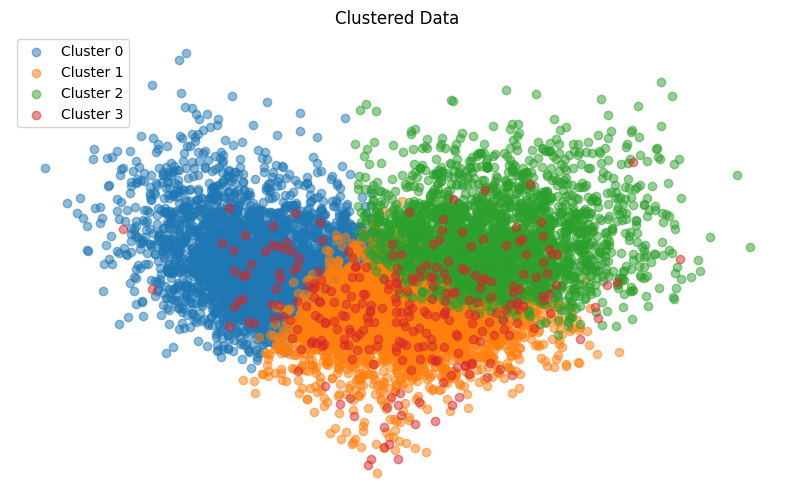

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)

#BnumClusters
for i in range(BnumClusters):
    # Gets an index of the samples that belong to the current cluster
    cluster_index = df1['kmeans_predictions'] == i
    ax.scatter(Breduced_data[cluster_index, 0], Breduced_data[cluster_index, 1], label=f'Cluster {i}', alpha=0.5)

ax.legend()
plt.xticks(())
plt.yticks(())
plt.title('Clustered Data')
plt.show()


IndexError: index 28 is out of bounds for axis 0 with size 28

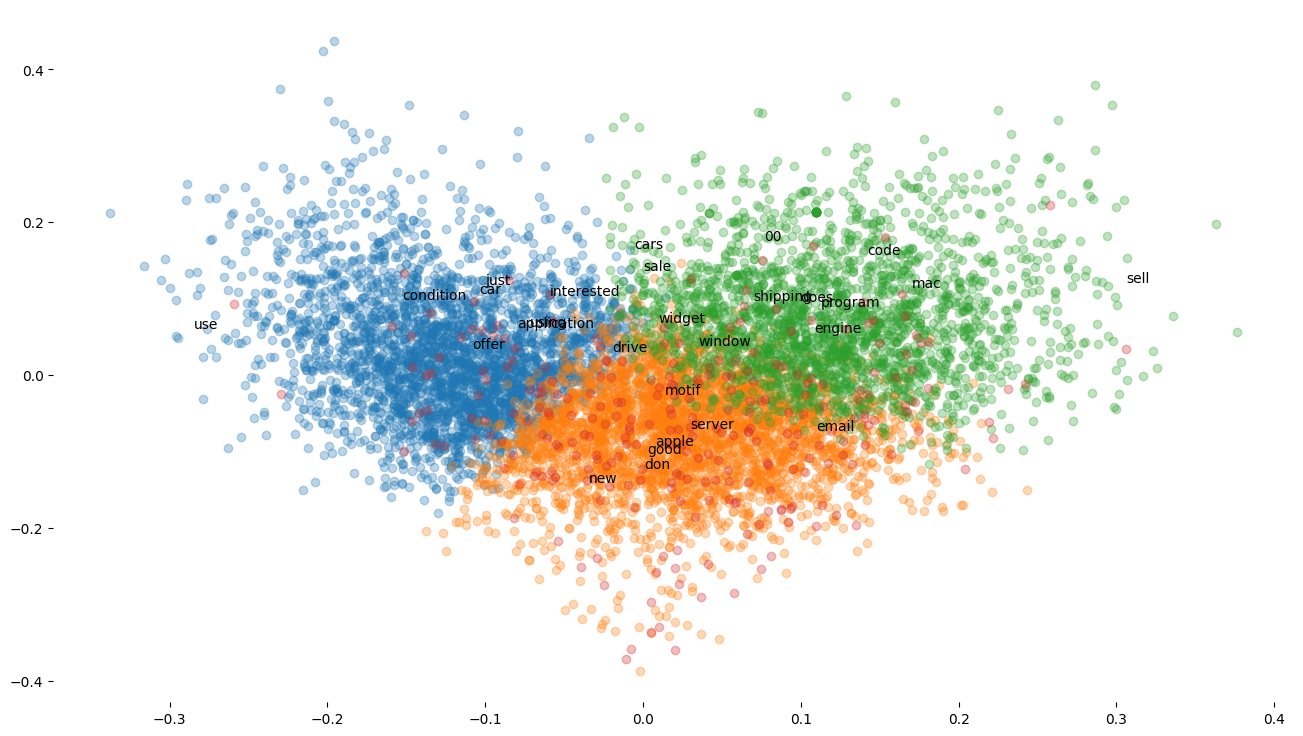

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
for i in range(BnumClusters):
    # Gets an index of the samples that belong to the current cluster
    cluster_index = df1['kmeans_predictions'] == i
    ax.scatter(Breduced_data[cluster_index, 0], Breduced_data[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [ ]:
num_unique_labels = len(set(Bkm.labels_))
num_categories = len(BnewsgroupsCategories)
num_categories
num_unique_labels

4

In [ ]:
num_categories

3

In [ ]:
# # Assuming `colordict` has colors for 3 known categories and we need a default color for any additional clusters
# default_color = 'gray'  # Choose a default color for extra clusters

# # Extend the `BnewsgroupsCategories` list with a default category for the extra cluster(s)
# extended_categories = BnewsgroupsCategories + ['default'] * (num_unique_labels - num_categories)

# # Now create the color list using the extended_categories list
# Bcolors_p = [colordict.get(extended_categories[l], default_color) for l in Bkm.labels_]


In [ ]:
# fig = plt.figure(figsize = (10,6))
# ax = fig.add_subplot(111)
# ax.set_frame_on(False)
# plt.scatter(Breduced_data[:, 0], Breduced_data[:, 1], color = colors_p, alpha = 0.5)
# plt.xticks(())
# plt.yticks(())
# plt.title('Predicted Clusters\n k = 4')
# plt.show()

In [ ]:
# Assuming 'Bkm' is your KMeans model and 'colordict' is your dictionary mapping cluster labels to colors
# And you have 4 clusters as indicated by 'num_unique_labels'

# Initialize an empty list to store colors
colors_p = []

# Loop through each label in your KMeans model's labels_
for label in Bkm.labels_:
    # Get the corresponding category for the label
    category = BnewsgroupsCategories[label] if label < len(BnewsgroupsCategories) else 'default'
    # Get the color for the category
    color = colordict.get(category, 'gray')  # Use a default color if the category is not found
    # Append the color to your list
    colors_p.append(color)

# Now colors_p should have the same length as Bkm.labels_ and hence Breduced_data


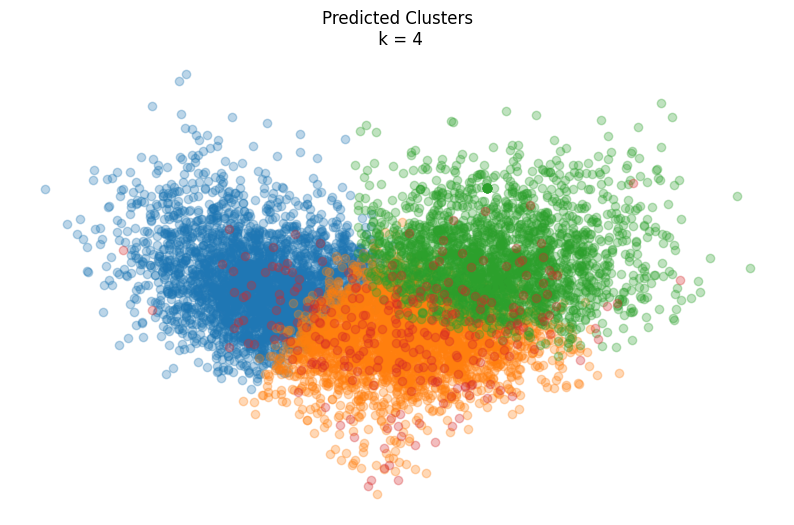

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
for i in range(BnumClusters):
    # Gets an index of the samples that belong to the current cluster
    cluster_index = df1['kmeans_predictions'] == i
    ax.scatter(Breduced_data[cluster_index, 0], Breduced_data[cluster_index, 1], label=f'Cluster {i}', alpha=0.3)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()


In [ ]:
Bkm3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
Bkm3.fit(BnewsgroupsTFVects.toarray())

KMeans(n_clusters=3)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


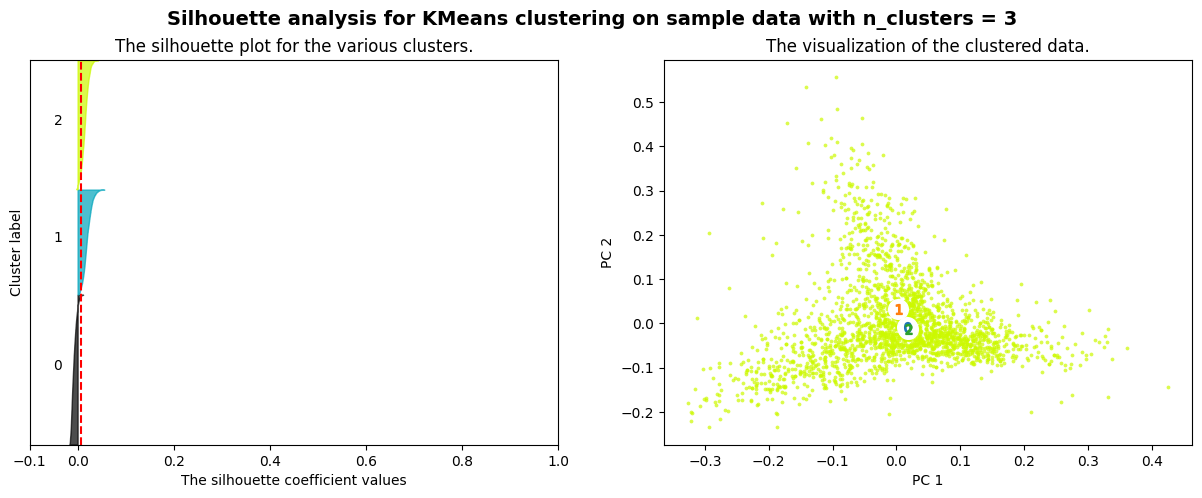

For n_clusters = 3, The average silhouette_score is : 0.007


In [ ]:
BX = BnewsgroupsTFVects.toarray()
plotSilhouette(3, BX)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


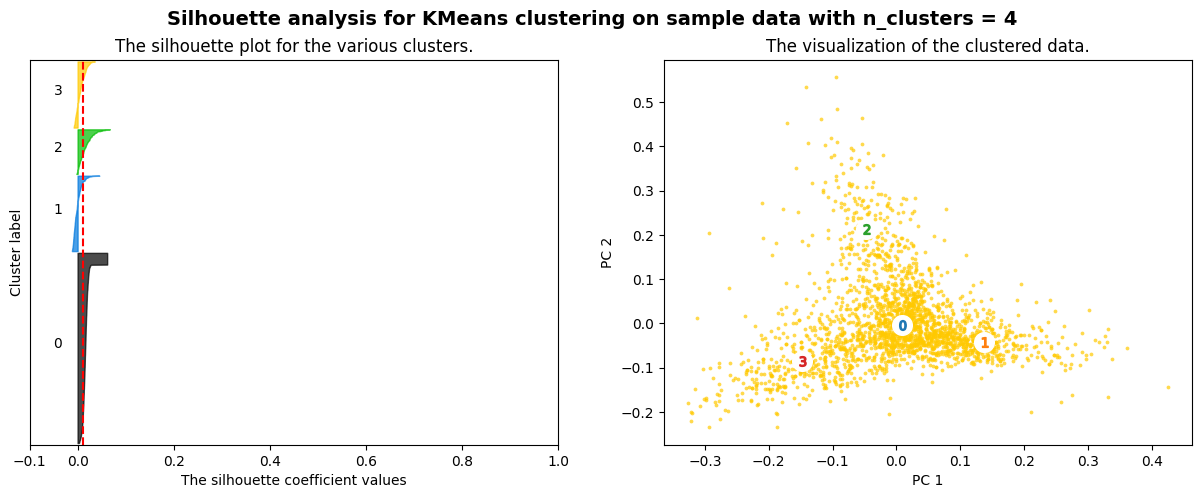

For n_clusters = 4, The average silhouette_score is : 0.012


In [ ]:
BX = newsgroupsTFVects.toarray()
plotSilhouette(4, BX)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


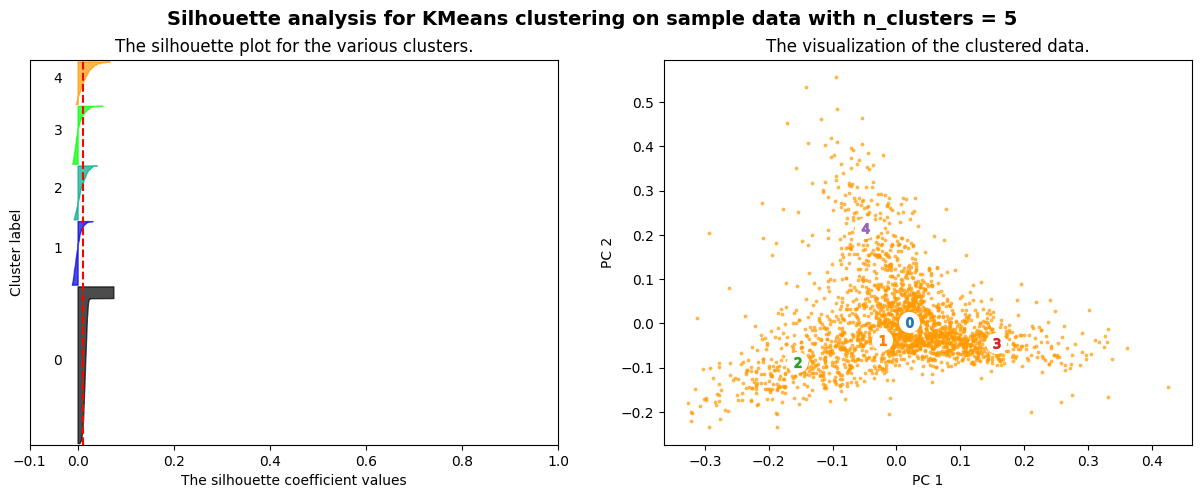

For n_clusters = 5, The average silhouette_score is : 0.011


In [ ]:
BX = newsgroupsTFVects.toarray()
plotSilhouette(5, BX)

<ipython-input-28-96d9ebbe3b48>:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


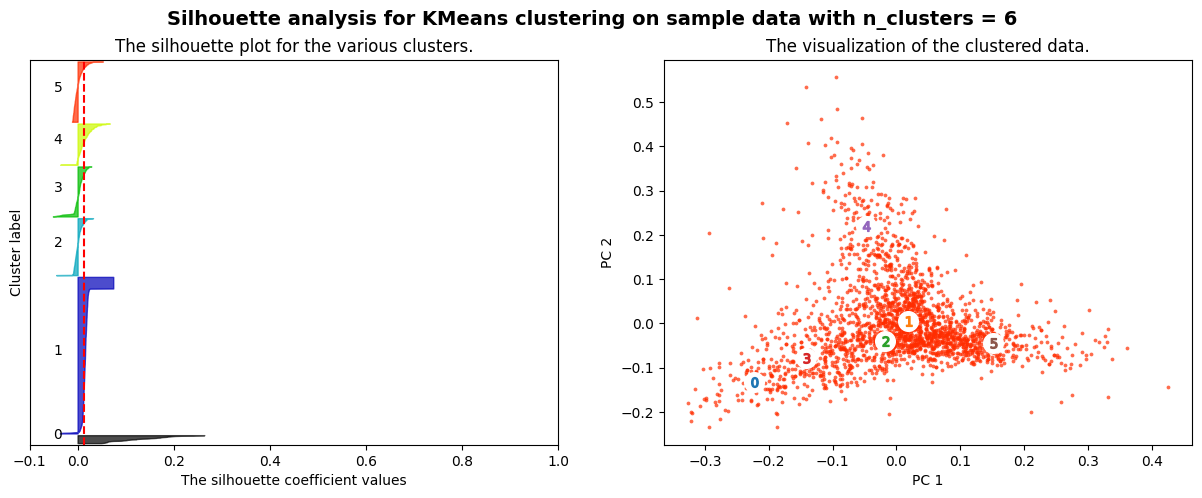

For n_clusters = 6, The average silhouette_score is : 0.013


In [ ]:
BX = newsgroupsTFVects.toarray()
plotSilhouette(6, BX)

# The silhouette scores above suggests that 6 is a better number of clusters than 3,4,5

In [ ]:
BReleasesTraining = pandas.read_csv("/content/drive/MyDrive/60000/burnoutcombined_csv.csv")


In [ ]:
BtargetDF = BReleasesTraining
BtextColumn = 'selftext'
BnumCategories = 3

In [ ]:
BexampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
BexampleTFVects = ngTFVectorizer.fit_transform(BtargetDF[BtextColumn])

In [ ]:
BexampleKM = sklearn.cluster.KMeans(n_clusters = BnumCategories, init='k-means++')
BexampleKM.fit(BexampleTFVects)

KMeans(n_clusters=3)

In [ ]:
BexamplePCA = sklearn.decomposition.PCA(n_components = 2).fit(BexampleTFVects.toarray())
BreducedPCA_data = BexamplePCA.transform(BexampleTFVects.toarray())

Bcolors = list(plt.cm.rainbow(np.linspace(0,1, BnumCategories)))
Bcolors_p = [Bcolors[l] for l in BexampleKM.labels_]

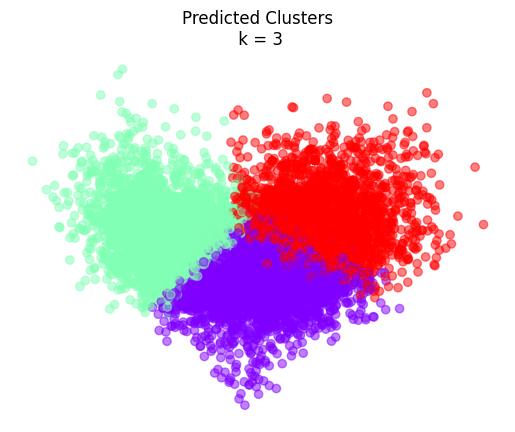

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(BreducedPCA_data[:, 0], BreducedPCA_data[:, 1], color = Bcolors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(BnumCategories))
plt.show()

In [ ]:
df1['kmeans_predictions'] = BexampleKM.labels_
df1

<ipython-input-90-84a3e793a3e5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['kmeans_predictions'] = BexampleKM.labels_


selftext          author  \
0     Hello fellow antiworkers, I just wanted to sha...     on_the_mike   
1     Anne Helen Peterson writes for Buzzfeed and ho...  unhappypatient   
2     I'll be frank, I'm probably older than a lot o...  unhappypatient   
3     I'm seriously burned out at work, which I've b...    throwavpdway   
4     Well, actually it's Not l as simple as work ma...       Necturion   
...                                                 ...             ...   
8980  I've got full blown social phobia, so despite ...        Rythen26   
8981  Ramble ahead: Almost completely monotone and s...       [deleted]   
8982  I'm not sure if this is an anxiety thing but t...       NiceKirby   
8983  I am a 29m with a 4 year old daughter and Part...       SkeebooXo   
8984  So New Year’s is around the corner. Instead of...     tolarewaju3   

      score  kmeans_predictions  
0        20                   0  
1        15                   0  
2        52                   1  
3        33                   1  
4       101                   1  
...     ...                 ...  
8980      4                   0  
8981     16                   1  
8982     22                   1  
8983      6                   1  
8984      3                   1  

[8985 rows x 4 columns]

### Cluster 0 contains terms like 'manager', 'new', 'burnout', which might relate to workplace issues or management.
### Cluster 1 has terms like 'anxiety', 'life', 'really', suggesting personal concerns or mental health topics.
### Cluster 3 includes words like 'burnt', 'working', 'jobs', indicating a focus on employment and perhaps job satisfaction or stress.

### We can see the different themes or topics involved in burnout emotions. For example, some clusters may reflect job stress, others may be related to the work environment, and others may be related to personal career growth or work-life balance challenges.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [ ]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [ ]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [ ]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [ ]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [ ]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 93.        ,  95.        ,   0.        ,   2.        ],
       [ 98.        , 200.        ,   0.        ,   3.        ],
       [126.        , 201.        ,   0.        ,   4.        ],
       [  5.        , 202.        ,   0.37033177,   5.        ],
       [ 69.        , 104.        ,   0.40914841,   2.        ],
       [ 10.        ,  44.        ,   0.44134524,   2.        ],
       [ 49.        ,  62.        ,   0.45096656,   2.        ],
       [ 51.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [  2.        ,  46.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

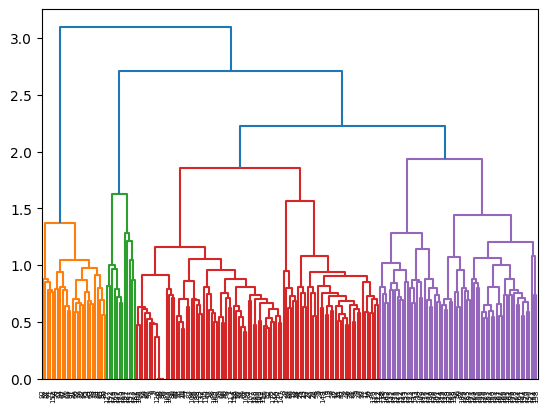

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

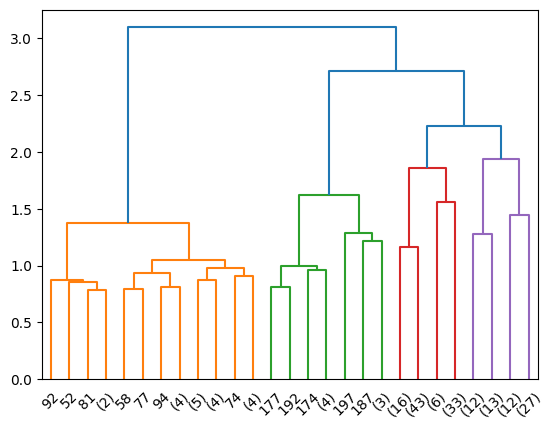

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1,
       1, 1, 3, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3,
       4, 3, 3, 1, 1, 3, 1, 3, 3, 1, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 1, 4,
       4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4, 3, 2, 2, 2,
       4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4, 4, 4, 4, 2,
       4, 3], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [ ]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  \
0     ../data/scikit_learn_data/20news_home/20news-b...                   0   
1     ../data/scikit_learn_data/20news_home/20news-b...                   0   
2     ../data/scikit_learn_data/20news_home/20news-b...                   0   
3     ../data/scikit_learn_data/20news_home/20news-b...                   0   
4     ../data/scikit_learn_data/20news_home/20news-b...                   0   
...                                                 ...                 ...   
2345  ../data/scikit_learn_data/20news_home/20news-b...                   0   
2346  ../data/scikit_learn_data/20news_home/20news-b...                   3   
2347  ../data/scikit_learn_data/20news_home/20news-b...                   3   
2348  ../data/scikit_learn_data/20news_home/20news-b...                   0   
2349  ../data/scikit_learn_data/20news_home/20news-b...                   0   

      wald_predictions  
0                    4  
1                    4  
2                    4  
3                    4  
4                    4  
...                ...  
2345                 4  
2346                 2  
2347                 2  
2348                 4  
2349                 4  

[2350 rows x 5 columns]

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [ ]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

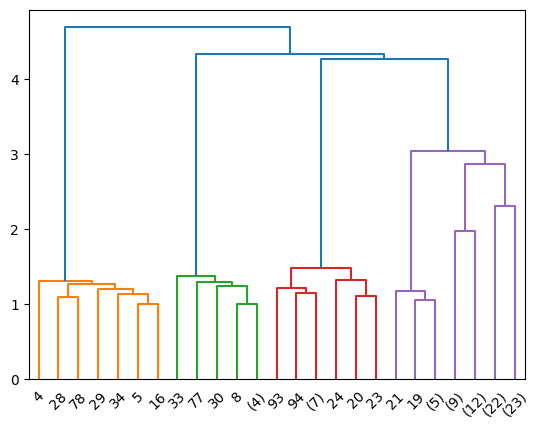

In [ ]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [ ]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)?

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [ ]:
BnewsgroupsTFVects

<8985x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 604167 stored elements in Compressed Sparse Row format>

In [ ]:
BnewsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.05476937, 0.        , ..., 0.        , 0.        ,
         0.03753334],
        ...,
        [0.        , 0.07249364, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.06073892, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
BnewsgroupsCoocMat = BnewsgroupsTFVects * BnewsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
BnewsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

In [ ]:
BselectIndices = []
BindexToCat = []
for Bc in set(df1['score']):
    BselectIndices += list(df1[df1['score'] == Bc].index)[:50]
    BindexToCat += [Bc] * 50
    #.groupby('category').sum()

In [ ]:
BsubCoocMat = BnewsgroupsCoocMat[BselectIndices,:][:,BselectIndices]

In [ ]:
Blinkage_matrix = scipy.cluster.hierarchy.ward(BsubCoocMat.toarray())
Blinkage_matrix[:10]

array([[3.10000000e+01, 3.20000000e+01, 1.41421356e+00, 2.00000000e+00],
       [3.30000000e+01, 2.19500000e+03, 1.41421356e+00, 3.00000000e+00],
       [3.40000000e+01, 2.19600000e+03, 1.41421356e+00, 4.00000000e+00],
       [9.90000000e+01, 2.19700000e+03, 1.41421356e+00, 5.00000000e+00],
       [1.55900000e+03, 1.62200000e+03, 1.41421356e+00, 2.00000000e+00],
       [2.80000000e+01, 2.90000000e+01, 1.41421356e+00, 2.00000000e+00],
       [3.00000000e+01, 2.20000000e+03, 1.41421356e+00, 3.00000000e+00],
       [2.19800000e+03, 2.20100000e+03, 1.41421356e+00, 8.00000000e+00],
       [2.33000000e+02, 2.34000000e+02, 1.41421356e+00, 2.00000000e+00],
       [7.78000000e+02, 9.72000000e+02, 1.48853337e+00, 2.00000000e+00]])

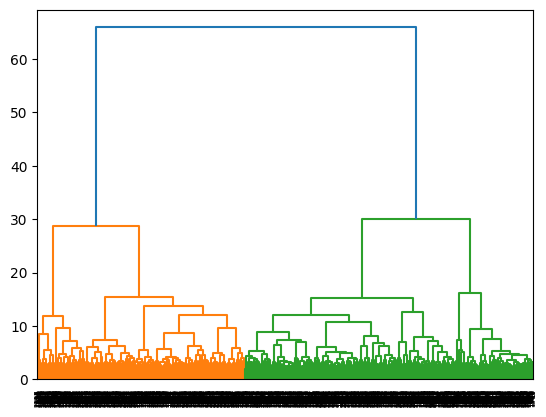

In [ ]:
BdendDat = scipy.cluster.hierarchy.dendrogram(Blinkage_matrix, get_leaves=True)

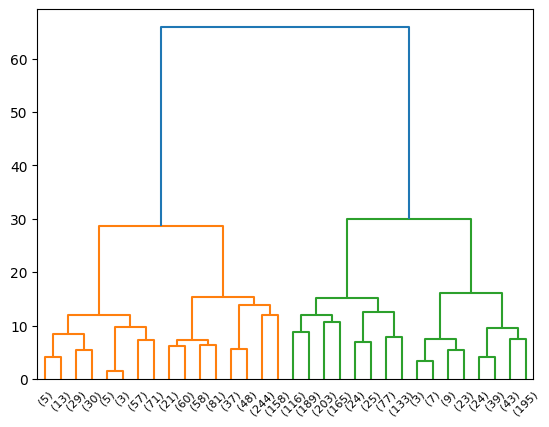

In [ ]:
BdendrogramDat = scipy.cluster.hierarchy.dendrogram(Blinkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [ ]:
BhierarchicalClusters = scipy.cluster.hierarchy.fcluster(Blinkage_matrix, 4, 'maxclust')
BhierarchicalClusters

array([3, 2, 2, ..., 3, 3, 4], dtype=int32)

In [ ]:
Blinkage_matrix_full = scipy.cluster.hierarchy.ward(BnewsgroupsCoocMat.toarray())
BhierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(Blinkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(df1['score'], BhierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(df1['score'], BhierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(df1['score'], BhierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(df1['score'], BhierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.026
Completeness: 0.059
V-measure: 0.036
Adjusted Rand Score: 0.003


In [ ]:
df1['wald_predictions'] = BhierarchicalClusters_full
df1

<ipython-input-115-60c542bdd4a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['wald_predictions'] = BhierarchicalClusters_full


selftext          author  \
0     Hello fellow antiworkers, I just wanted to sha...     on_the_mike   
1     Anne Helen Peterson writes for Buzzfeed and ho...  unhappypatient   
2     I'll be frank, I'm probably older than a lot o...  unhappypatient   
3     I'm seriously burned out at work, which I've b...    throwavpdway   
4     Well, actually it's Not l as simple as work ma...       Necturion   
...                                                 ...             ...   
8980  I've got full blown social phobia, so despite ...        Rythen26   
8981  Ramble ahead: Almost completely monotone and s...       [deleted]   
8982  I'm not sure if this is an anxiety thing but t...       NiceKirby   
8983  I am a 29m with a 4 year old daughter and Part...       SkeebooXo   
8984  So New Year’s is around the corner. Instead of...     tolarewaju3   

      score  kmeans_predictions  wald_predictions  
0        20                   0                 1  
1        15                   0                 1  
2        52                   1                 2  
3        33                   1                 3  
4       101                   1                 2  
...     ...                 ...               ...  
8980      4                   0                 4  
8981     16                   1                 2  
8982     22                   1                 4  
8983      6                   1                 2  
8984      3                   1                 4  

[8985 rows x 5 columns]

In [ ]:
BexampleCoocMat = BexampleTFVects * BexampleTFVects.T
BexampleCoocMat.setdiag(0)
Bexamplelinkage_matrix = scipy.cluster.hierarchy.ward(BexampleCoocMat[:100, :100].toarray())

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


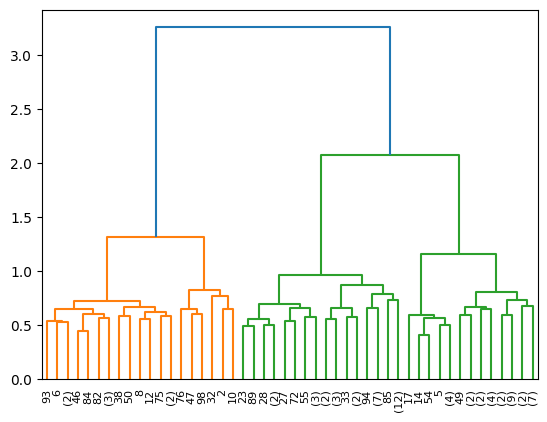

In [ ]:
Bax = scipy.cluster.hierarchy.dendrogram(Bexamplelinkage_matrix, p=5, truncate_mode='level')

In [ ]:
Bexample_linkage_matrix_full = scipy.cluster.hierarchy.ward(BexampleCoocMat.toarray())
Bexample_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(Bexample_linkage_matrix_full, 4, 'maxclust')

In [ ]:
Bexample_hierarchicalClusters_full

array([1, 1, 2, ..., 4, 2, 4], dtype=int32)

For our complete clusters:
Homogeneity: 0.026
Completeness: 0.059
V-measure: 0.036
Adjusted Rand Score: 0.003

K-mean For n_clusters = 6, The average silhouette_score is : 0.013

From Homogeneity and Completeness The result may good than K-amean?

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

Here again we make use of `lucem_illud` functions. The source code of both of these is in [processing.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/processing.py).

In [ ]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

In [ ]:
senReleasesTraining[::100]

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [ ]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [ ]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [ ]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

First we can visualize as a stacked bar chart:

In [ ]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [ ]:
senlda.show_topic(1)

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

In [ ]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

### Heirarchial Dirichlet Process

We use LDA topic modeling above, but a similar alternative model you may run across is Hierarchical Dirichlet Processes, a nonparametric generalization of LDA. See, for example, [Teodoridis et al 2020](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3596233). One difference is how the researcher selects the number of topics.

In [ ]:
from gensim.models import HdpModel

In [ ]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [ ]:
hdpmodel.print_topics()

Gensim sets the default number of topics as 150. This [stack overflow link](https://stackoverflow.com/questions/31543542/hierarchical-dirichlet-process-gensim-topic-number-independent-of-corpus-size) walks you through how to truncate these topics.

In [ ]:
hdptexts = hdpmodel[corpus]

In [ ]:
hdptexts[0]

This [HDP tutorial](https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a) walks us through alternative HDP implementations outside of gensim.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font>

In [ ]:
#Apply our functions
BtargetDF['tokenized_text'] = BtargetDF['selftext'].apply(lambda x: lucem_illud.word_tokenize(x))
BtargetDF['normalized_tokens'] = BtargetDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
BtargetDF[::100]

selftext  \
0     Hello fellow antiworkers, I just wanted to sha...   
100    "Fuck the evil person who insists on hiring y...   
200   This is my life right now, temporarily. Just s...   
300   I feel anti work isn't quite right and anti jo...   
400   When your colleagues come into work at 9am aft...   
...                                                 ...   
8500  I'm burned out from school, but this is my fin...   
8600  I strongly recognize that therapy is a huge wa...   
8700  A few weeks ago my workload got bigger when we...   
8800  I (23) have many big, hard to achieve goals th...   
8900  I was in low-key panic for a whole day and fel...   

                                                  title  score  is_self  \
0                        Sooo tired and want to quit...     20     True   
100                                              PREACH     24     True   
200                           I love being a housewife.     71     True   
300                              Anti work or anti job?     28     True   
400                                     Pure exhaustion     34     True   
...                                                 ...    ...      ...   
8500      Can you recover from burnout without a break?      1     True   
8600                  I want to quit therapy, should I?      1     True   
8700  I took off a week from my call center job, wha...      1     True   
8800  (burnout+depression) how do you approach worki...      3     True   
8900                I had an interview and got selected      9     True   

     created_utc_converted      id                author  num_comments  \
0      2018-11-28 17:59:12  a18lsu           on_the_mike            15   
100    2020-06-29 12:15:46  hhyrz4         solidstate125             2   
200    2021-01-26 21:02:33  l5nkyf           rabbitscape            24   
300    2021-05-26 23:15:42  nlu6d6    mostlikelyarealboy             9   
400    2021-09-07 09:40:35  pjjslf         robinthehoode             0   
...                    ...     ...                   ...           ...   
8500   2022-09-02 20:30:17  x4bmri  Confusedconfusion250             5   
8600   2022-10-10 19:45:39  y0o2no             catboy519             0   
8700   2022-11-20 02:43:18  yzt4tb           Blueangel27             1   
8800   2022-12-24 08:20:23  zu5fcb             catboy519             1   
8900   2021-02-04 10:13:05  lccoab            Ok-Try5560             0   

                                                    url  Burnout evaluation  \
0     https://www.reddit.com/r/antiwork/comments/a18...                 1.0   
100   https://www.reddit.com/r/antiwork/comments/hhy...                 1.0   
200   https://www.reddit.com/r/antiwork/comments/l5n...                 1.0   
300   https://www.reddit.com/r/antiwork/comments/nlu...                 1.0   
400   https://www.reddit.com/r/antiwork/comments/pjj...                 1.0   
...                                                 ...                 ...   
8500  https://www.reddit.com/r/mentalhealth/comments...                 1.0   
8600  https://www.reddit.com/r/mentalhealth/comments...                 1.0   
8700  https://www.reddit.com/r/mentalhealth/comments...                 1.0   
8800  https://www.reddit.com/r/mentalhealth/comments...                 1.0   
8900  https://www.reddit.com/r/socialanxiety/comment...                 1.0   

                                         tokenized_text  \
0     [Hello, fellow, antiworkers, I, just, wanted, ...   
100   [Fuck, the, evil, person, who, insists, on, hi...   
200   [This, is, my, life, right, now, temporarily, ...   
300   [I, feel, anti, work, is, n't, quite, right, a...   
400   [When, your, colleagues, come, into, work, at,...   
...                                                 ...   
8500  [I, 'm, burned, out, from, school, but, this, ...   
8600  [I, strongly, recognize, that, therapy, is, a,...   
8700  [A, few, weeks, ago, my, workload, got, bigger...   
8800  [I,

In [ ]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

BtargetDF['reduced_tokens'] = BtargetDF['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [ ]:
Bdictionary = gensim.corpora.Dictionary(BtargetDF['reduced_tokens'])

In [ ]:
Bcorpus = [Bdictionary.doc2bow(text) for text in BtargetDF['reduced_tokens']]

In [ ]:
gensim.corpora.MmCorpus.serialize('Bsenate.mm', Bcorpus)
Bsenmm = gensim.corpora.MmCorpus('Bsenate.mm')

In [ ]:
Bsenlda = gensim.models.ldamodel.LdaModel(corpus=Bsenmm, id2word=Bdictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
Bsen1Bow = Bdictionary.doc2bow(BtargetDF['reduced_tokens'][0])
Bsen1lda = Bsenlda[Bsen1Bow]
print("The topics of the text: {}".format(BtargetDF['author'][0]))
print("are: {}".format(Bsen1lda))

The topics of the text: on_the_mike
are: [(5, 0.20471352), (6, 0.17286828), (8, 0.11606452), (9, 0.4973781)]


In [ ]:
BldaDF = pandas.DataFrame({
        'author' : BtargetDF['author'],
        'topics' : [Bsenlda[Bdictionary.doc2bow(l)] for l in BtargetDF['reduced_tokens']]
    })

In [ ]:
#Dict to temporally hold the probabilities
BtopicsProbDict = {i : [0] * len(BldaDF) for i in range(Bsenlda.num_topics)}

#Load them into the dict
for Bindex, BtopicTuples in enumerate(BldaDF['topics']):
    for BtopicNum, Bprob in BtopicTuples:
        BtopicsProbDict[BtopicNum][Bindex] = Bprob

#Update the DataFrame
for BtopicNum in range(Bsenlda.num_topics):
    BldaDF['Btopic_{}'.format(BtopicNum)] = BtopicsProbDict[BtopicNum]

BldaDF[1::100]

author                                             topics  \
1           unhappypatient  [(4, 0.29328504), (5, 0.20024891), (6, 0.14358...   
101               zuziite1  [(5, 0.51685643), (6, 0.3329184), (8, 0.142711...   
201          maple_tiddies  [(4, 0.0970798), (5, 0.067319624), (6, 0.82892...   
301      Noodler_Canoodler                  [(5, 0.7777136), (9, 0.20406426)]   
401    IonlyusethrowawaysA                  [(2, 0.2390122), (9, 0.73458135)]   
...                    ...                                                ...   
8501        DemWasSumBirds  [(3, 0.53601515), (4, 0.23442508), (8, 0.03230...   
8601  Pristine-Awareness-7                 [(2, 0.21049957), (4, 0.76032645)]   
8701          MrBaboon1234  [(2, 0.5924699), (6, 0.34796795), (7, 0.042088...   
8801      storybooktattoos  [(3, 0.6772491), (4, 0.29845676), (5, 0.018654...   
8901          Monthly_Vent  [(3, 0.016453417), (4, 0.95777786), (7, 0.0234...   

      Btopic_0  Btopic_1  Btopic_2  Btopic_3  Btopic_4  Btopic_5  Btopic_6  \
1          0.0       0.0  0.000000  0.000000  0.293285  0.200249  0.143586   
101        0.0       0.0  0.000000  0.000000  0.000000  0.516856  0.332918   
201        0.0       0.0  0.000000  0.000000  0.097080  0.067320  0.828926   
301        0.0       0.0  0.000000  0.000000  0.000000  0.777714  0.000000   
401        0.0       0.0  0.239012  0.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
8501       0.0       0.0  0.000000  0.536015  0.234425  0.000000  0.000000   
8601       0.0       0.0  0.210500  0.000000  0.760326  0.000000  0.000000   
8701       0.0       0.0  0.592470  0.000000  0.000000  0.000000  0.347968   
8801       0.0       0.0  0.000000  0.677249  0.298457  0.018655  0.000000   
8901       0.0       0.0  0.000000  0.016453  0.957778  0.000000  0.000000   

      Btopic_7  Btopic_8  Btopic_9  
1     0.000000  0.360391  0.000000  
101   0.000000  0.142712  0.000000  
201   0.000000  0.000000  0.000000  
301   0.000000  0.000000  0.204064  
401   0.000000  0.000000  0.734581  
...        ...       ...       ...  
8501  0.000000  0.032306  0.185672  
8601  0.000000  0.000000  0.000000  
8701  0.042089  0.000000  0.000000  
8801  0.000000  0.000000  0.000000  
8901  0.023467  0.000000  0.000000  

[90 rows x 12 columns]

In [ ]:
BldaDFV = BldaDF[:10][['Btopic_%d' %x for x in range(10)]]
BldaDFVisN = BldaDF[:10][['author']]
BldaDFVis = BldaDFV.values
BldaDFVisNames = BldaDFVisN.values
BldaDFV

Btopic_0  Btopic_1  Btopic_2  Btopic_3  Btopic_4  Btopic_5  Btopic_6  \
0       0.0       0.0  0.000000  0.000000  0.057198  0.221181  0.193072   
1       0.0       0.0  0.000000  0.000000  0.293285  0.200249  0.143586   
2       0.0       0.0  0.000000  0.224384  0.332370  0.025278  0.294339   
3       0.0       0.0  0.000000  0.184626  0.686292  0.000000  0.120657   
4       0.0       0.0  0.000000  0.176523  0.511747  0.000000  0.000000   
5       0.0       0.0  0.000000  0.000000  0.502822  0.028237  0.000000   
6       0.0       0.0  0.000000  0.460022  0.188563  0.090681  0.180905   
7       0.0       0.0  0.116212  0.000000  0.000000  0.870741  0.000000   
8       0.0       0.0  0.049764  0.015243  0.000000  0.930567  0.000000   
9       0.0       0.0  0.000000  0.720855  0.012483  0.000000  0.000000   

   Btopic_7  Btopic_8  Btopic_9  
0  0.000000  0.088180  0.433876  
1  0.000000  0.360391  0.000000  
2  0.000000  0.020752  0.102367  
3  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.305354  
5  0.000000  0.447648  0.000000  
6  0.000000  0.000000  0.077286  
7  0.000000  0.000000  0.000000  
8  0.000000  0.000000  0.000000  
9  0.219894  0.000000  0.000000

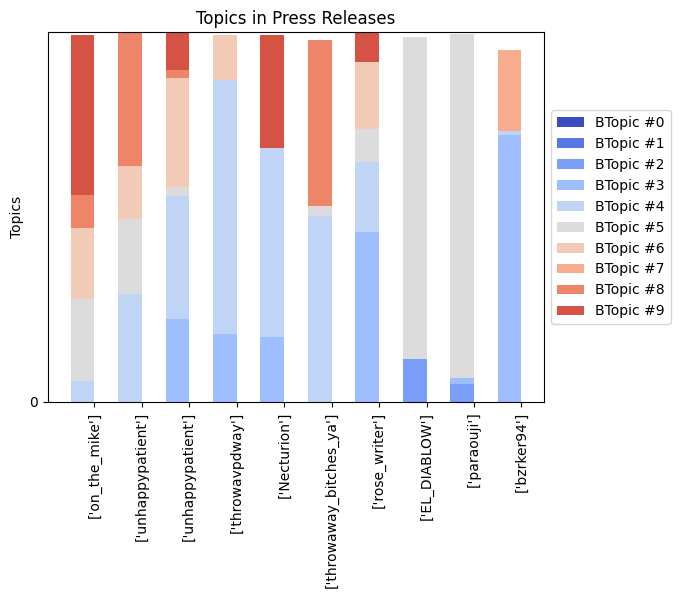

In [ ]:
BN = 10
Bind = np.arange(BN)
BK = Bsenlda.num_topics  # N documents, K topics
Bind = np.arange(BN)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
Bheight_cumulative = np.zeros(BN)

for k in range(BK):
    color = plt.cm.coolwarm(k/BK, 1)
    if k == 0:
        p = plt.bar(Bind, BldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(Bind, BldaDFVis[:, k], width, bottom=Bheight_cumulative, color=color)
    Bheight_cumulative += BldaDFVis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(Bind+width/2, BldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['BTopic #{}'.format(k) for k in range(BK)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

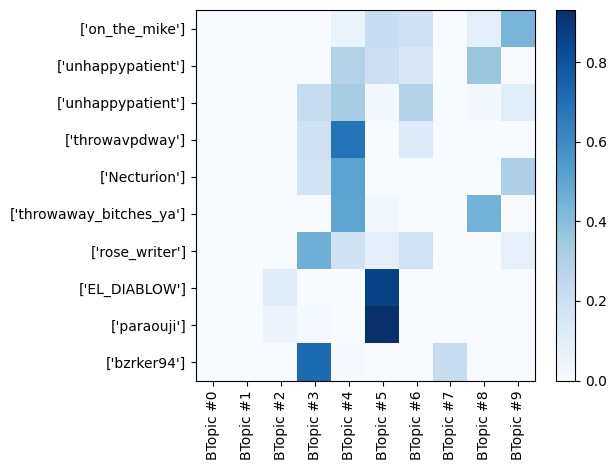

In [ ]:
plt.pcolor(BldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(BldaDFVis.shape[0])+0.5, BldaDFVisNames);
plt.xticks(np.arange(BldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [ ]:
Bsenlda.show_topic(1)

[('nursing', 0.026923774),
 ('patients', 0.023148194),
 ('patient', 0.021294547),
 ('nurse', 0.016545804),
 ('nurses', 0.014397997),
 ('hospital', 0.011547774),
 ('feel', 0.009035422),
 ('harming', 0.00828304),
 ('uncle', 0.00682757),
 ('feeling', 0.0041506332)]

In [ ]:
BtopicsDict = {}
for BtopicNum in range(Bsenlda.num_topics):
    BtopicWords = [w for w, p in Bsenlda.show_topic(BtopicNum)]
    BtopicsDict['Topic_{}'.format(BtopicNum)] = BtopicWords

BwordRanksDF = pandas.DataFrame(BtopicsDict)
BwordRanksDF

Topic_0   Topic_1   Topic_2  Topic_3     Topic_4  Topic_5     Topic_6  \
0        feel   nursing  position     feel        feel     feel     company   
1      things  patients    mental   things     feeling    hours  experience   
2  experience   patient      feel    think      things     boss        feel   
3      career     nurse   company  anxiety     friends  getting      career   
4        love    nurses   manager  started      mental  company         got   
5  healthcare  hospital     hours      lot       think   things      degree   
6     started      feel    things      bad       tired      got       field   
7         lot   harming      love  getting  depression  started    position   
8      stress     uncle  employee      got     anxiety     told       think   
9   insurance   feeling   getting   social     started      lot        told   

      Topic_7  Topic_8  Topic_9  
0        feel     feel      got  
1       hours  company     told  
2        hour   things    think  
3      burned  manager  anxiety  
4     company    hours     went  
5      advice     team  started  
6    applying      lot   things  
7  interviews      got      lot  
8      mental  getting    thing  
9    position    sales      bad

<Figure size 640x480 with 0 Axes>

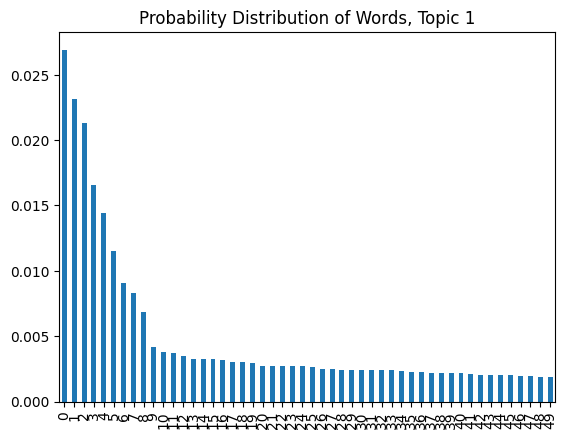

In [ ]:
Btopic1_df = pandas.DataFrame(Bsenlda.show_topic(1, topn=50))
plt.figure()
Btopic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

In [ ]:
Bsenlda1 = gensim.models.ldamodel.LdaModel(corpus=Bsenmm, id2word=Bdictionary, num_topics=10, eta = 0.00001)
Bsenlda2 = gensim.models.ldamodel.LdaModel(corpus=Bsenmm, id2word=Bdictionary, num_topics=10, eta = 0.9)

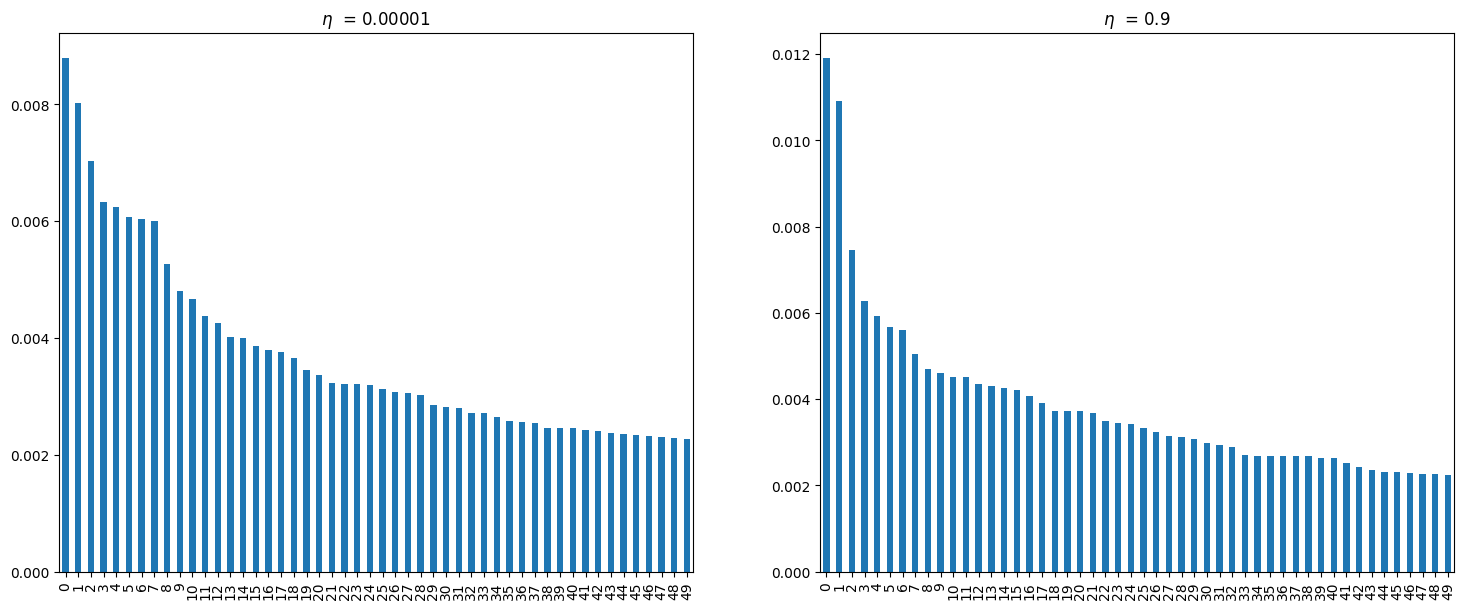

In [ ]:
Btopic11_df = pandas.DataFrame(Bsenlda1.show_topic(1, topn=50))
Btopic21_df = pandas.DataFrame(Bsenlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
Btopic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
Btopic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

In [ ]:
from gensim.models import HdpModel

In [ ]:
Bhdpmodel = HdpModel(corpus=Bcorpus, id2word=Bdictionary)

In [ ]:
Bhdpmodel.print_topics()

In [ ]:
Bhdptexts = Bhdpmodel[corpus]

In [ ]:
hdptexts[0]

###The fewer the number of topics, the more the number of topics, the more general the topic, while the more the number of topics, the more specific the topic may be, but may be less coherent.

### The words associated with Topic_1 such as "nursing", "patients", "nurse","hospital", and related terms suggest that this topic primarily deals with healthcare. The inclusion of terms like "feel harming" and "feeling" alongside these healthcare-related words points to a focus on the emotional experiences within the healthcare sector, potentially highlighting issues of caregiver stress, patient empathy, and the psychological impact of hospital work. The word "burnout" appearing in this context underscores the emotional exhaustion that healthcare professionals may be discussing or experiencing.

### Other topics with words like "job", "interview", "career", "manager", and "work" indicate discussions around professional life and employment. These topics seem to capture sentiments related to job satisfaction, the job search process, workplace environment, and career development.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does. `lucem_illud.loadDavies` can be found in [loaders.py](https://github.com/UChicago-Computational-Content-Analysis/lucem_illud/blob/main/lucem_illud/loaders.py).

In [ ]:
corpora_address = "/Downloads/SOAP"


In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about.

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally.

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution']
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution']
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/.


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about.

(An acknowledgement - Bhargav (the author of most of this class's code) wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Downloads/COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts, and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])

    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice.

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4

    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [ ]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

For future research, you can also consider the Structural Topic Model (STM), which can integrate any covariates (e.g., time, author, document length) into your topic model. Unfortunately there is not yet an implementation of this in Python, but there is a wonderful [R package](https://www.structuraltopicmodel.com/) authored by Molly Roberts, Brandon Stewart, and Dustin Tingley.

Here are plate diagrams of LDA and STM, which may help you visualize the way STM adds covariates to the "left" and "right" of the standard LDA model.

<img src="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" alt="https://raw.githubusercontent.com/UChicago-Computational-Content-Analysis/Homework-Notebooks/main/week-3/img/lda_stm_plate_diagrams.jpg" style="width:500px">



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [ ]:
BtargetDF

selftext  \
0     Hello fellow antiworkers, I just wanted to sha...   
1     Anne Helen Peterson writes for Buzzfeed and ho...   
2     I'll be frank, I'm probably older than a lot o...   
3     I'm seriously burned out at work, which I've b...   
4     Well, actually it's Not l as simple as work ma...   
...                                                 ...   
8980  I've got full blown social phobia, so despite ...   
8981  Ramble ahead: Almost completely monotone and s...   
8982  I'm not sure if this is an anxiety thing but t...   
8983  I am a 29m with a 4 year old daughter and Part...   
8984  So New Year’s is around the corner. Instead of...   

                                                  title  score  is_self  \
0                        Sooo tired and want to quit...     20     True   
1     I have a feeling this essay will be meaningful...     15     True   
2     What makes you hate work? What were you doing ...     52     True   
3                Burned out, suicidal and about to snap     33     True   
4     Suicidal from working or am I just a trash human?    101     True   
...                                                 ...    ...      ...   
8980   I desperately need a new job, but I'm terrified.      4     True   
8981            Always being told how I have no emotion     16     True   
8982  Does anyone else just not enjoy texting/callin...     22     True   
8983                          Something needs to change      6     True   
8984  3 Questions to Help You Overcome Social Anxiet...      3     True   

     created_utc_converted      id          author  num_comments  \
0      2018-11-28 17:59:12  a18lsu     on_the_mike            15   
1      2019-01-07 14:50:17  adico2  unhappypatient             2   
2      2019-01-10 19:07:02  aem94t  unhappypatient            49   
3      2019-01-31 06:42:45  alms99    throwavpdway            10   
4      2019-02-04 08:20:16  amzoi6       Necturion            22   
...                    ...     ...             ...           ...   
8980   2022-12-15 00:38:31  zm7b0y        Rythen26             0   
8981   2022-12-21 16:09:43  zrseqd       [deleted]             3   
8982   2022-12-22 23:14:44  zszwjh       NiceKirby             1   
8983   2022-12-23 09:03:03  ztasks       SkeebooXo             1   
8984   2022-12-28 02:00:28  zwx5v4     tolarewaju3             0   

                                                    url  Burnout evaluation  \
0     https://www.reddit.com/r/antiwork/comments/a18...                 1.0   
1     https://www.reddit.com/r/antiwork/comments/adi...                 1.0   
2     https://www.reddit.com/r/antiwork/comments/aem...                 1.0   
3     https://www.reddit.com/r/antiwork/comments/alm...                 1.0   
4     https://www.reddit.com/r/antiwork/comments/amz...                 1.0   
...                                                 ...                 ...   
8980  https://www.reddit.com/r/socialanxiety/comment...                 1.0   
8981  https://www.reddit.com/r/socialanxiety/comment...                 1.0   
8982  https://www.reddit.com/r/socialanxiety/comment...                 1.0   
8983  https://www.reddit.com/r/socialanxiety/comment...                 1.0   
8984  https://www.reddit.com/r/socialanxiety/comment...                 1.0   

                                         tokenized_text  \
0     [Hello, fellow, antiworkers, I, just, wanted, ...   
1     [Anne, Helen, Peterson, writes, for, Buzzfeed,...   
2     [I, 'll, be, frank, I, 'm, probably, older, th...   
3     [I, 'm, seriously, burned, out, at, work, whic...   
4     [Well, actually, it, 's, Not, l, as, simple, a...   
...                                                 ...   
8980  [I, 've, got, full, blown, social, phobia, so,...   
8981  [Ramble, ahead, Almost, completely, monotone, ...   
8982  [I, 'm, not, sure, if, this, is, an, anxiety, ...   
8983  [I, am, a, 29, m, with, a, 4, year, old, daugh...   
8984  [So, New, Year, 

In [ ]:
BtargetDF4 = BtargetDF[['author', 'tokenized_text']]

In [ ]:
BtargetDF4

author                                     tokenized_text
0        on_the_mike  [Hello, fellow, antiworkers, I, just, wanted, ...
1     unhappypatient  [Anne, Helen, Peterson, writes, for, Buzzfeed,...
2     unhappypatient  [I, 'll, be, frank, I, 'm, probably, older, th...
3       throwavpdway  [I, 'm, seriously, burned, out, at, work, whic...
4          Necturion  [Well, actually, it, 's, Not, l, as, simple, a...
...              ...                                                ...
8980        Rythen26  [I, 've, got, full, blown, social, phobia, so,...
8981       [deleted]  [Ramble, ahead, Almost, completely, monotone, ...
8982       NiceKirby  [I, 'm, not, sure, if, this, is, an, anxiety, ...
8983       SkeebooXo  [I, am, a, 29, m, with, a, 4, year, old, daugh...
8984     tolarewaju3  [So, New, Year, ’s, is, around, the, corner, I...

[8985 rows x 2 columns]

In [ ]:
Bdool = BtargetDF4['tokenized_text'][9]

In [ ]:
' '.join(Bdool[0:1500])

"I just wanted to share this video I found that reflects a point I 've been seeing here a lot on this sub Watching this video breaks my heart in some way Burn Out by Jake Roper](https://youtu.be E71hfeUWl2w"

In [ ]:
Bcharacters = {}
for Btoken in Bdool:
    if Btoken[0] == '@':
        # all characters or actions start with @, so we add that to character
        if Btoken[2:] not in Bcharacters:
            Bcharacters[Btoken[2:]] = 0
        if Btoken[2:] in Bcharacters:
            Bcharacters[Btoken[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
Bactor_network = nx.Graph()

In [ ]:
for Bcharacter in Bcharacters:
    if Bcharacters[Bcharacter] > 2000:
        Bactor_network.add_node(Bcharacter, lines_spoken= Bcharacters[Bcharacter], words=[])

In [ ]:
i = 0

In [ ]:
Ball_texts = []

In [ ]:
for Btoken in Bdool:
    i += 1
    if i > len(Bdool):
        break
    if Btoken[0] == "burnout":
        if Btoken[2:] in Bactor_network.nodes():
            j = i
            for Btoken_ in Bdool[i:]:
                if Btoken_[0] == "burnout":
                    # if both the characters exist in the graph, add a weight
                    if Btoken_[2:] != Btoken[2:] and Btoken_[2:] in Bactor_network.nodes():
                        if (Btoken[2:], Btoken_[2:]) not in Bactor_network.edges():
                            Bactor_network.add_edge(Btoken[2:], Btoken_[2:], weight=0)
                        if (Btoken[2:], Btoken_[2:]) in Bactor_network.edges():
                            Bactor_network.edges[(Btoken[2:], Btoken_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            Bactor_network.nodes[token[2:]]['words'].Bappend(dool[i:j])
            Ball_texts.append(lucem_illud.normalizeTokens(Bdool[i:j]))

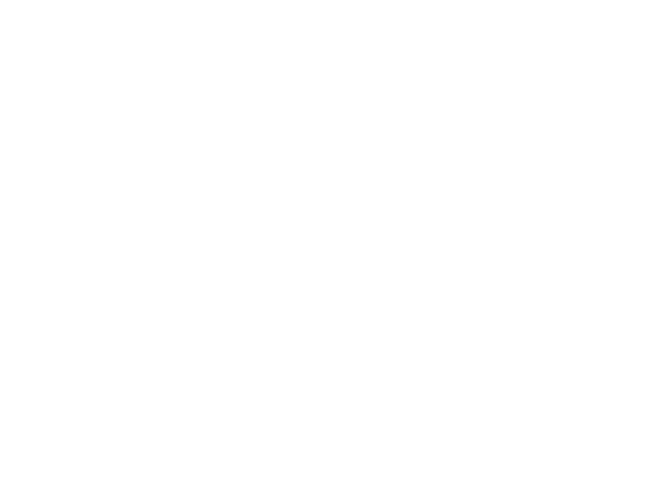

In [ ]:
nx.draw(Bactor_network, with_labels=True, font_weight='bold')

In [ ]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

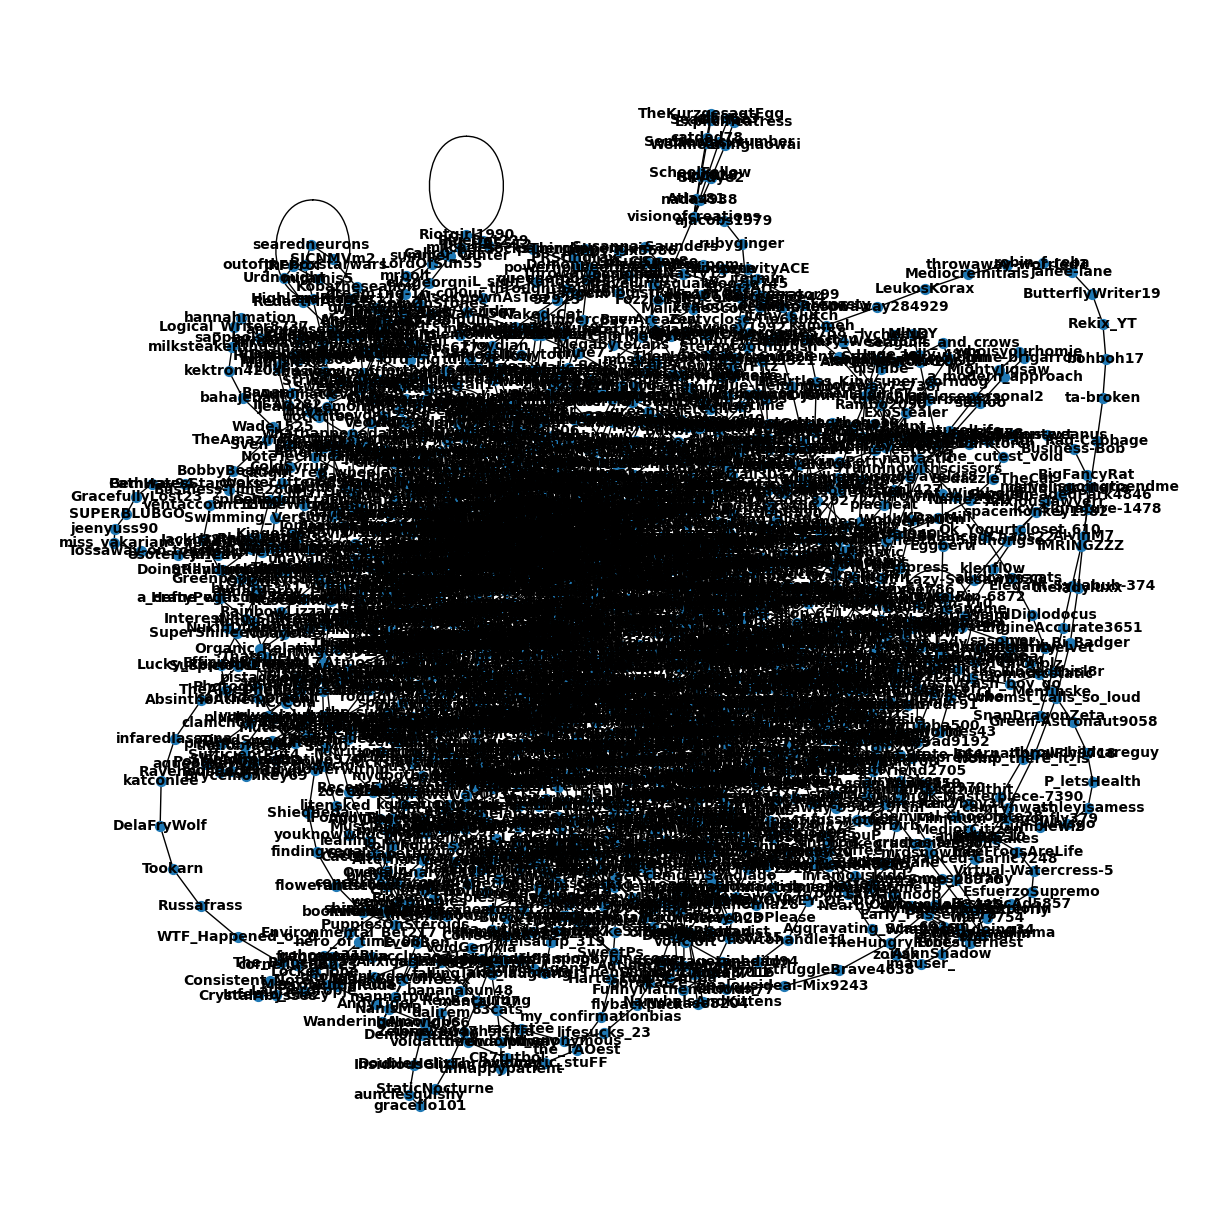

In [ ]:
Bactor_network = nx.Graph()

keyword = 'burnout'

for index, row in BtargetDF.iterrows():
    author = row['author']
    tokenized_text = row['tokenized_text']

    if keyword in tokenized_text:
        if author not in Bactor_network:
            Bactor_network.add_node(author)


        for prev_index in range(index - 1, -1, -1):
            prev_row = BtargetDF.iloc[prev_index]
            prev_author = prev_row['author']
            prev_tokenized_text = prev_row['tokenized_text']

            if keyword in prev_tokenized_text:

                if Bactor_network.has_edge(author, prev_author):
                    Bactor_network[author][prev_author]['weight'] += 1
                else:
                    Bactor_network.add_edge(author, prev_author, weight=1)
                break

plt.figure(figsize=(12,12))

nx.draw(Bactor_network, with_labels=True, font_weight='bold', node_size=50, font_size=10)

plt.show()

In [254]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [255]:
corpora_address = "/content/drive/MyDrive/60000/SOAP"

In [280]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=5)

text_9-jtw.zip
text_8-sbo.zip


In [281]:
import zipfile
import pandas as pd

In [282]:
soap_dict = {}

In [283]:
zip_file_path = '/content/drive/MyDrive/60000/SOAP/text_8-sbo.zip'

In [262]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    zip_ref.extractall('/content/extracted_files')

    print(f"Extracted {len(zip_ref.namelist())} files:")
    for file_name in zip_ref.namelist():
        print(file_name)


Extracted 1 files:
text_8-sbo.txt


In [263]:
first_file_name = zip_ref.namelist()[0]
with open(f'/content/extracted_files/{first_file_name}', 'r') as f:
    content = f.read(100)
    print(f"Contents of {first_file_name}: {content}")

Contents of text_8-sbo.txt: 
@@8 @!Tad: J.R . , what did you mean it 's your fault ? @!J.R.: Nothing . Forget it . @!Dixie: Swee


In [284]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [285]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [286]:
soap_dict = {}

In [287]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [288]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [289]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [290]:
i = 0

In [291]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [292]:
soap_df

Soap Name                                    Tokenized Texts
0      All My Childen  [@!Laura, Hey, may, I, join, you, @!Leo, Yeah,...
1  As the World Turns  [@!Lucinda, Because, it, 's, an, emergency, si...
2  Bold and Beautiful  [@!Eric, All, right, yes, @(Morgan, thinking, ...
3   Days of Our Lives  [@!Chloe, So, do, we, have, enough, gas, to, g...
4    General Hospital  [@!Monica, Your, so, called, daughter, is, goi...
5       Guiding Light  [@!Tony, Hey, is, this, Is, this, your, handwr...
6    One Life to Live  [@!R.J., Interesting, @!Lindsay, Interesting, ...
7            Passions  [@!Julian, Let, 's, drink, up, It, 's, not, ev...
8        Port Charles  [@!Garcia, You, 're, accused, of, felony, hit,...
9  Young and Restless  [@!Matt, Is, this, the, screaming, you, did, l...

In [293]:
dool = soap_df['Tokenized Texts'][9]

In [295]:
' '.join(dool[0:1500])

"@!Matt Is this the screaming you did last time You do n't recognize me You should I made sure I hid them for you the night I slipped them in the marguerita It was n't the booze that made you out of it I have my private little stash If you take these you wo n't feel anything It 's kind of a waste do n't you think I 've waited too long for this Sharon It 's payback time @!Victoria You sure you 're up for it @!Ryan I 'm fine @!Victoria You okay Is this @!Nikki No I 'm not okay @!Victoria Still no word from Dad @!Nikki I called him a little while ago to ease Cassie 's mind He 's he was still quite a distance from where the cabin is @!Victoria He 'll make it there in time mother He has to @!Mack Getting ready to take off @!Billy Yeah I better Your grandmother wanted me to make sure you got to bed second wind if you want to hang around for a while longer @!Billy Something on your mind Mack @!Mack I 'm thinking about how well you and Raul are getting along now @!Billy Still it 's not like we

In [296]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [297]:
import networkx as nx

In [298]:
actor_network = nx.Graph()

In [299]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [300]:
i = 0

In [301]:
all_texts = []

In [302]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud.normalizeTokens(dool[i:j]))

/usr/local/lib/python3.10/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


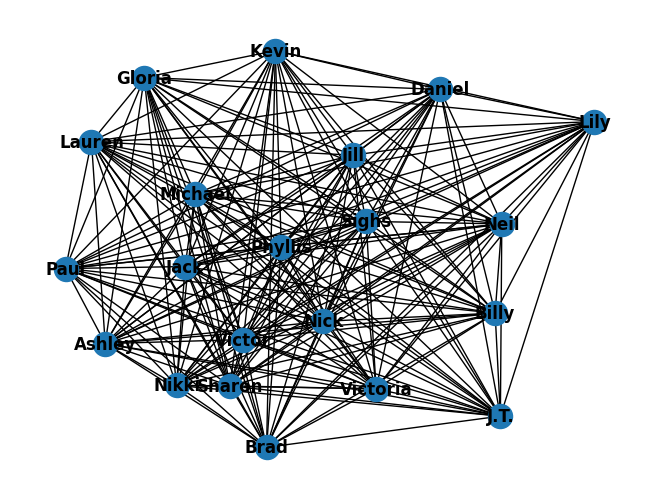

In [303]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [304]:
all_texts[0:10]

[['sure'],
 ['okay'],
 ['m', 'okay'],
 ['word', 'dad'],
 ['called', 'little', 'ago', 'ease', 'cassie', 'mind', 'distance', 'cabin'],
 ['time', 'mother'],
 ['yeah',
  'better',
  'grandmother',
  'wanted',
  'sure',
  'got',
  'bed',
  'wind',
  'want',
  'hang',
  'longer'],
 ['mind', 'mack'],
 ['like', 'solved', 'problems'],
 ['know', 'lot', 'mack']]

In [305]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [306]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [307]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [308]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [309]:
doollda.show_topics()

[(0,
  '0.158*"right" + 0.107*"uh" + 0.051*"need" + 0.022*"said" + 0.020*"happy" + 0.020*"m" + 0.014*"trying" + 0.014*"baby" + 0.013*"talk" + 0.013*"nature"'),
 (1,
  '0.128*"to" + 0.116*"go" + 0.045*"m" + 0.039*"sure" + 0.034*"let" + 0.029*"mom" + 0.024*"think" + 0.018*"stop" + 0.015*"happened" + 0.015*"huh"'),
 (2,
  '0.202*"okay" + 0.057*"mm" + 0.047*"hmm" + 0.034*"thought" + 0.024*"lot" + 0.022*"victor" + 0.020*"bye" + 0.019*"michael" + 0.016*"stay" + 0.013*"nikki"'),
 (3,
  '0.038*"love" + 0.032*"know" + 0.024*"life" + 0.023*"better" + 0.017*"idea" + 0.017*"father" + 0.016*"believe" + 0.016*"hold" + 0.015*"away" + 0.015*"feel"'),
 (4,
  '0.140*"yeah" + 0.133*"know" + 0.069*"want" + 0.023*"adam" + 0.020*"told" + 0.019*"hi" + 0.016*"talk" + 0.016*"victoria" + 0.016*"mean" + 0.015*"kind"'),
 (5,
  '0.093*"like" + 0.043*"look" + 0.038*"know" + 0.030*"way" + 0.022*"hell" + 0.020*"little" + 0.020*"new" + 0.017*"soon" + 0.016*"excuse" + 0.015*"thinking"'),
 (6,
  '0.076*"thank" + 0.039*"

In [310]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud.normalizeTokens(actor_all_words))]

In [311]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Victoria [(0, 0.3881163), (2, 0.09779915), (3, 0.06663404), (4, 0.15358754), (5, 0.12670444), (8, 0.0408695), (9, 0.12628546)]
Nikki [(0, 0.39719865), (2, 0.09641443), (3, 0.06824407), (4, 0.15397479), (5, 0.12652321), (8, 0.04041913), (9, 0.11722217)]
Billy [(0, 0.39297616), (2, 0.09277833), (3, 0.069810875), (4, 0.15211864), (5, 0.12850323), (8, 0.039970525), (9, 0.123835966)]
J.T. [(0, 0.39469698), (2, 0.09451857), (3, 0.07030552), (4, 0.15342091), (5, 0.12623297), (8, 0.040920928), (9, 0.11989738)]
Jack [(0, 0.39080173), (2, 0.09847913), (3, 0.06503115), (4, 0.15682557), (5, 0.12974411), (8, 0.03963996), (9, 0.1194758)]
Phyllis [(0, 0.38437405), (2, 0.099697426), (3, 0.069324955), (4, 0.14965807), (5, 0.13142829), (8, 0.039680995), (9, 0.12583351)]
Michael [(0, 0.39542863), (2, 0.099372074), (3, 0.06625294), (4, 0.15991828), (5, 0.12410183), (8, 0.03741643), (9, 0.117506936)]
Sharon [(0, 0.3857288), (2, 0.09857727), (3, 0.069550976), (4, 0.1528957), (5, 0.12728263), (8, 0.043721728

In [312]:
from gensim.matutils import kullback_leibler

In [313]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [314]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution']
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution']
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

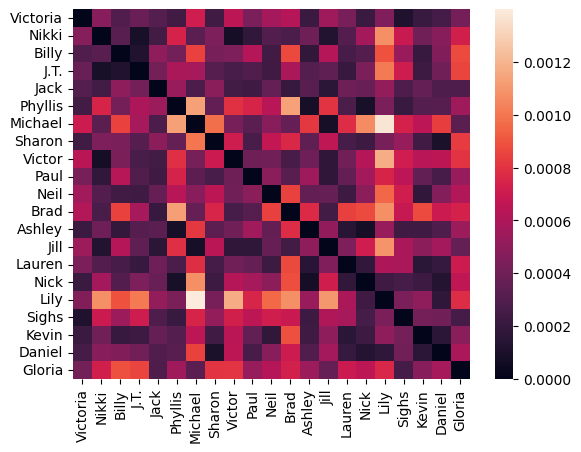

In [315]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [321]:
corpora_address1 = "/content/drive/MyDrive/60000/COHA"

In [322]:
coha_texts = lucem_illud.loadDavies(corpora_address1, return_raw=True)

text_1990s_bsj.zip
text_2000s_scc.zip


In [323]:
list(coha_texts.keys())[0:5]

['mag_1990_339761.txt',
 'mag_1990_339762.txt',
 'mag_1990_339763.txt',
 'mag_1990_339764.txt',
 'mag_1990_339765.txt']

In [324]:
coha_genres = {}
coha_years = {}

In [325]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])

    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])

In [326]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [327]:
coha_years.keys()

dict_keys(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009'])

In [328]:
import collections

In [329]:
years = []
year_lens = []

In [330]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [331]:
years[0], years[-1]

('1990', '2009')

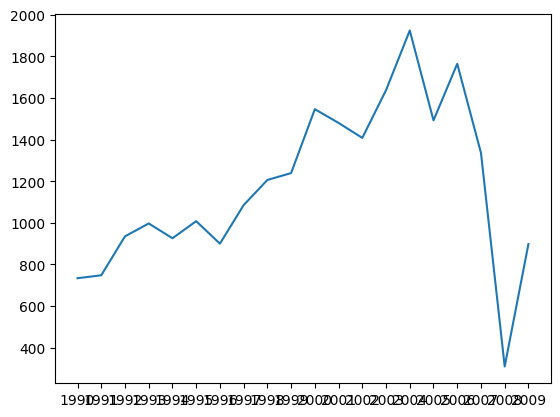

In [332]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

In [333]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [340]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

In [ ]:
# for i, (year, articles) in enumerate(sorted(coha_years.items())):
#     large_files = 0
#     for article in articles:
#         try:
#             article_len = len(article[2])
#             if article_len < 1500000:
#                 all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
#             else:
#                 large_files += 1
#         except IndexError:
#             continue

#     # Determine the timeslice index once per year
#     if i < 70:
#         timeslice_index = 0
#     elif i < 103:
#         timeslice_index = 1
#     elif i < 140:
#         timeslice_index = 2
#     elif i < 180:
#         timeslice_index = 3
#     else:
#         timeslice_index = 4

#     docs_per_timeslice[timeslice_index] += len(articles) - large_files


In [341]:
# import random

# SAMPLE_RATE = 0.1

# for i, (year, articles) in enumerate(sorted(coha_years.items())):
#     sampled_articles = random.sample(articles, int(len(articles) * SAMPLE_RATE))

# MAX_ARTICLE_LENGTH = 1000000

# for article in sampled_articles:
#     if len(article[2]) < MAX_ARTICLE_LENGTH:
#         pass

In [342]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [343]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [344]:
small_corpus = choose_n(all_texts_coha, docs_per_timeslice, nums=100)

In [345]:
final_corpus= []

In [346]:
docs_per_time_slice = [0, 0, 0, 0, 0]

In [347]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4

    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [348]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [349]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [350]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [351]:
from gensim.models import ldaseqmodel

In [352]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [353]:
ldaseq.print_topics(time=0)[1]

[('>', 0.03933168400587313),
 ('p', 0.03932770890121656),
 ('<', 0.03932385567157708),
 ('says', 0.007517772335682825),
 ('$', 0.004828792914286863),
 ('said', 0.004181413470014934),
 ('time', 0.0038891089788002683),
 ('people', 0.003714178855250418),
 ('like', 0.0032025491841606206),
 ('year', 0.002956341301256167),
 ('new', 0.00255299627749101),
 ('u.s', 0.0021401297036520274),
 ('world', 0.0020947859567757013),
 ('years', 0.0020390583837094287),
 ('food', 0.0019912978368710884),
 ('iraq', 0.0019312205710769444),
 ('home', 0.0019062817003117653),
 ('american', 0.0016504170876973966),
 ('children', 0.0016046282786784988),
 ('day', 0.0015978784894745313)]

In [354]:
ldaseq.print_topics(time=4)[1]

[('>', 0.03880892332181629),
 ('p', 0.03880673047277552),
 ('<', 0.03880390854782999),
 ('says', 0.00737948122900484),
 ('$', 0.005466645753836971),
 ('time', 0.004070668548615717),
 ('people', 0.003997399214114335),
 ('said', 0.003834406000821365),
 ('year', 0.0033548717560359016),
 ('like', 0.003280034620136332),
 ('new', 0.0026229252905556858),
 ('u.s', 0.0025182007864698627),
 ('world', 0.002495866450798028),
 ('food', 0.0021923395528663284),
 ('american', 0.0019548793840629165),
 ('home', 0.0019368518504489455),
 ('years', 0.00189921769641815),
 ('week', 0.001830102277085695),
 ('day', 0.0018259926829595245),
 ('children', 0.0014875374858171213)]

In [358]:
ldaseq.save("ldaseqmodel")

In [359]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")

**### topic children'from , 0.0016046282786784988 to 0.0014875374858171213, We can see that the frequency of the topic "children" is slowly decreasing, and the topics such as "world" "U.S", "food","american"is slowly increasing, "iraq" disappeared into these topics**